# Assigment 1, part3  
Link to github : https://github.com/HugoCote/Assignment-1-Part-3/  
  
### Members of the team :  
- Srinivas Venkattaramanujam   
- Jean-Philippe Gagnon Fleury    
- Ahmadreza Godarzvandchegini   
- Hugo Côté   

We recommend reading this directly via the jupyter notebook and not from the pdf. Some cells (e.g. vizualizing feature maps) are interactive and their outputs cannot be included in the pdf.  
The objective of this part is to devise a neural network to classify a dataset of cats and dogs. The training set includes 20000 images whereas the test set consists of 5000 unlabeled images.

In [0]:
# deep learning library
import torch
import torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init # to initialize model
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# we use torch.cuda.Event(enable_timing=True) to measure time
# if you don't have cuda, you can use instead :
# from timeit import default_timer as timer
# import time

import collections # for ordered_dictionnary
import copy        # for copy.deepcopy( ... )
import math        # for ceiling function

# to display plot
import matplotlib.pyplot as plt 
import numpy as np              

# to import data
from __future__ import print_function, division
import os
from PIL import Image           # 
import pandas as pd
from skimage import io, transform 

import datetime                 # to format time in strings

import IPython.display # to display .png inside the notebook

#### Some cells could require a long time to evaluate,   
to warn the user that the evaluation of one such cell is completed, it outputs a sound.

In [0]:
from IPython.display import Audio
wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
# the following command line produces sound and is used after cells that 
# require more time to execute :
Audio(wave, rate=10000, autoplay=True)

#### If you did not liked that sound, you should disable it  
By setting want_lound_warning to false.

In [0]:
want_lound_warning = False

#### To perfrom the hyper-parameters search, we use the following library  :  
It can be installed with the following command :  
- pip install sobol_seq

In [0]:
# !pip install sobol_seq
import sobol_seq

### Import the data used for training and validation  
And instantiate two datasets, one with and one without data augmentation.  
We tried different intensity of data augmentation. We named them :  
- high  
- medium  
- medium-low  
- low
- normal (no data augmentation)   

The differents transformations used for augmentation are :
  - Random horizontal flip  
  - Random resize and crop
  - Randomly converting to grayscale
  - Random rotation
  
  


In [0]:
random_seed= 2019 # for reproducibility 
batch_size = 8
# fraction of samples that will belong to the validation dataset
validation_split = .10 
shuffle_dataset = True
num_workers = 0        # dataloader issues with numworkers > 0

# used to scale tensor from [0 to 1] to [0 to 255]
# Without this, with the hyper-parameters tested, the models stay at 
# 50% accuracy
def multby255 (pic) :
    return pic.mul(255)

# setting up data loader directory for training and validation
root = './data_catdogs/trainset/'

# different ways to augment the data
data_transforms = {
    'high': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(90, scale=(0.80, 1.0), ratio=(0.75, 1.25), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'medium': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomResizedCrop(80, scale=(0.85, 1.0), ratio=(0.8, 1.2), interpolation=2),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'medium-low': transforms.Compose([
        transforms.RandomGrayscale(p=0.4),
        transforms.RandomChoice([
            transforms.RandomHorizontalFlip(p=0.75),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(64, scale=(0.95, 1.0), ratio=(0.95, 1.05))
        ]),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'low': transforms.Compose([
        transforms.RandomGrayscale(p=0.15),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ]),
    'normal': transforms.Compose([
        transforms.ToTensor(),
        transforms.Lambda(multby255)
    ])
}

# to be able to train and valide on both the original and the augmented dataset
train_dataset_augm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["medium-low"])
train_dataset_norm = torchvision.datasets.ImageFolder(root=root,transform=data_transforms["normal"])

# Creating data indices for training and validation splits:
train_dataset_size = len(train_dataset_augm)
indices = list(range(train_dataset_size))
split = int(np.floor(validation_split * train_dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating data samplers:
train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
valid_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

# The following code show how to instantiate dataloader for the training and validation datasets.
batch_size = 32
train_norm_loader = DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
train_augm_loader = DataLoader(train_dataset_augm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_norm_loader = DataLoader(train_dataset_norm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
valid_augm_loader = DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

#### Compute and display the size of each dataset    

We made a 10% split :  
- 10% of labelled pictures belong to the validation dataset   
- 90% of labelled pictures belong to the training dataset  

In [0]:
dummy_train_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=train_sampler, num_workers=0)
dummy_valid_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=1, sampler=valid_sampler, num_workers=0)
train_dataset_size  = dummy_train_loader.__len__()
valid_dataset_size   = dummy_valid_loader.__len__()
print("training   dataset size : " , train_dataset_size)
print("validation dataset size : " , valid_dataset_size)
del dummy_train_loader 
del dummy_valid_loader 

training   dataset size :  17999
validation dataset size :  1999


### Display some samples  
Using data augmentation. This is usefull to confirm that the augmented data preserve enough informations about the original data to be relevant for training i.e. pictures are not so modified that a human is not able to label them.

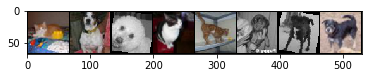

    0     1     1     0     0     1     1     1


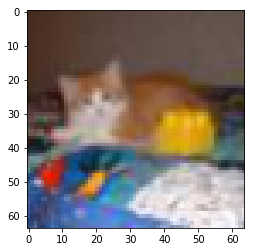

In [0]:
batch_size = 8
pict_n_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
pict_a_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)

# function to show an image
def imshow(img):
    npimg = img.numpy()  / 255
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

for i, (images, labels) in enumerate(pict_a_loader) :
    if i > 0 : break
    # show images
    imshow(torchvision.utils.make_grid(images ))
    # print labels
    print(' '.join('%5s' % labels[j].item() for j in range(min(batch_size,8))))
    sample_image = images[0]

imshow(torchvision.utils.make_grid( sample_image ))

## Set the device

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## The models  
Here, we define the models that we will be using for the remaining of the notebook. They are all described.  

Architecture of Classifier inspired by : https://github.com/MaximumEntropy/welcome_tutorials/tree/pytorch/pytorch

In [0]:
class Classifier5(nn.Module):
    """
    Classifier5 :
    7 Convolutional layers using stride=1, no dilatation and padding to assure 
    same convolution, all having :
        - kernel of size 3 (first 3 layers) or 5 (last 4 layers)
        - double the number of feature maps received from the previous layer
        - followed by ReLU non-linearity 
        - and non-overlapping max pooling with kernel of size 2 
        - which means that each layer (made of those 3 steps) :
            - receive as input n  feature maps of size 2m x 2m
            - return  as outpu 2n feature maps of size  m x  m
    With the exeption of :
        - the 4th layer does not have a max pooling
        - the last layer does not have ReLU non-linearity
    After the convolutional part of the model, the original 3x64x64 input 
    picture is now a 512x1x1 vector.
    The 7 conv. layers are followed by one fully connected linear layer
    For the output of this model to be seen as a probabilie dist., it has to 
    be fed to a F.softmax(...,dim=-1)
    """
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,3,3,3,3,3])
        pad = kernel_sz // 2 
        
        super(Classifier5, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5, input size = 8^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 4^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, input size = 2^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            # nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)           
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = self.fct1b(x)
        return x
    
    def to_string(self):
        depth_to_string = "The depth of this model is fixed to 8"
        return depth_to_string + self.__doc__

In [0]:
class Classifier5d(nn.Module):
    """
    Classifier5d, old version of Classifier5
    7 Convolutional layers using stride=1, no dilatation and padding to assure 
    same convolution, all having :
        - kernel of size 3 (first 3 layers) or 5 (last 4 layers)
        - double the number of feature maps received from the previous layer
        - followed by ReLU non-linearity 
        - and non-overlapping max pooling with kernel of size 2 
        - which means that each layer (made of those 3 steps) :
            - receive as input n  feature maps of size 2m x 2m
            - return  as outpu 2n feature maps of size  m x  m
    With the exeption of :
        - the 4th layer does not have a max pooling
        - the last layer has tanh non-linearity
    After the convolutional part of the model, the original 3x64x64 input 
    picture is now a 512x1x1 vector.
    The 7 conv. layers are followed by one fully connected layer ending 
    with softmax non-linearity.
    """
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5d, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5, input size = 8^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 4^2
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 7, input size = 2^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.Tanh(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2)
        )
        self.fct1b = nn.Linear(1*1*512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1,1*1*512)
        x = F.relu(self.fct1b(x))
        x = F.softmax(x,dim=-1)
        return x
    
    def to_string(self):
        depth_to_string = "The depth of this model is fixed to 8"
        return depth_to_string + self.__doc__

In [0]:
class Classifier7(nn.Module):
    """
    Classifier7 :
    6 Convolutional layers using stride=1, no dilatation and padding to assure 
    same convolution, all having :
        - kernel of size 3 (first 3 layers) or 5 (last 4 layers)
        - double the number of feature maps received from the previous layer
        - followed by ReLU non-linearity 
        - and non-overlapping max pooling with kernel of size 2 
        - which means that each layer (made of those 3 steps) :
            - receive as input n  feature maps of size 2m x 2m
            - return  as outpu 2n feature maps of size  m x  m
    With the exeption of :
        - the 4th and 6th layer does not have a max pooling
    After the convolutional part of the model, the original 3x64x64 input 
    picture is now a 512x4x4 vector.
    The 7 conv. layers are followed by two fully connected layer :
        - the first as ReLU activation
        - the last is linear
    For the output of this model to be seen as a probabilie dist., it has 
    to be fed to a F.softmax(...,dim=-1)
    """
    def __init__(self ):
        
        kernel_sz = np.array([5,5,5,3,3,3,3,3])
        pad = kernel_sz // 2 
        
        super(Classifier7, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5, input size = 8^2
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2),
            
            # Layer 6, input size = 4^2
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU()     
        )
        # 
        self.fct1 = nn.Linear(4*4*512, 512)
        self.fct2 = nn.Linear(512, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size()[0],-1)
        x = F.relu(self.fct1(x))
        x = self.fct2(x)
        return x
    
    def to_string(self):
        depth_to_string = "The depth of this model is fixed to 8"
        return depth_to_string + self.__doc__

Model with vgg-like architecture, inspired by :  
https://pytorch.org/docs/0.4.0/_modules/torchvision/models/vgg.html

In [0]:
class VGGClassifier(nn.Module):
    """
    VGGClassifier : a vgg-like model :
    The first part of the model is a made of 2 types of layers:
        A - a same convolution with kernel of size 3, padding of 1, no 
            dilatation, stride = 1, with ReLU activations
        B - non-overlapping max pooling with kernel of size 2
    Each layer of type A :
        - can change the number of feature channels i.e. takes n1 feature 
          channels and returns n2
        - will keep unchanged the size of the feature maps
    Each layer of type B :
        - will keep unchanged the number of feature channels and divide by 
          2 the size of the feature maps
    The model takes as input a list channels_list that indicates which layers 
    are of type A and B :
        - the number indicates a layer of type A and correspond to the number
          of feature channels of its output
        - \'M\' for max-pooling indicates a layer of type B 
    After the convolutional part of the model, the original 3x64x64 input 
    picture is now a vector.
    If there is 6 \'M\' on the channels_list (because of the size of the 
    input, there cannot be more than 6), the size of this vector is the number 
    of feature maps of the last layer of the convolutional part.
    The convolutional part is followed by 3 fully connected layer, the first 
    two have ReLU activations. The parameter size can be used to increase the 
    size of this part of the model. For the output of this model to be seen as 
    a probabilie dist., it has to be fed to a F.softmax(...,dim=-1)
    """
    def __init__(self,
                 channels_list = [50,'M',100,'M',150,200,'M',250,300,350,'M',400,450,'M',500,525,'M',550], 
                 size = 500
                ):
        self.size   = size
        self.channels_list = channels_list
        self.depth  = 0
        
        for i in channels_list:
            if i == 'M' :
                continue
            self.depth += 1
            
        conv_out_channels = 0
        for i in reversed(channels_list) :
            if i == 'M' : 
                continue
            conv_out_channels = i
            break
            
        super(VGGClassifier, self).__init__()
        self.features = self.make_layers(self.channels_list)
        self.classifier = nn.Sequential(
            nn.Linear(conv_out_channels, self.size),
            nn.ReLU(inplace=True),
            nn.Linear(self.size, self.size),
            nn.ReLU(inplace=True),
            nn.Linear(self.size, 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

    def make_layers(self, channels_list):
        layers = []
        in_channels = 3
        for v in channels_list:
            if v == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, v, kernel_size=3, padding=1)]
                layers += [nn.ReLU(inplace=True)]
                in_channels = v
        return nn.Sequential(*layers)
    
    def to_string(self):
        depth_to_string = "The depth of this instance is : {d}".format(d=self.depth)
        return depth_to_string + self.__doc__

# Assignment Questions

In the following, we specifically addressed the questions asked regarding Problem 3.

## Question 1  

Describe the architecture (number of layers, filter sizes, pooling, etc.), and report the number of parameters.
You can take inspiration from some modern deep neural network architectures such as the VGG networks to improve the performance. 

## Number of parameters in each model:  
Using the following function, we may analyze the number of parameters in each models:

In [0]:
def number_of_params( net , display_comp = False ) :
    nb_param  = 0
    depth     = 0 # count the number of different bias
    param_lst = " "
    for i, (key, value) in enumerate( net.state_dict().items() ) :
        if key.endswith("bias") :
            depth = depth + 1
            
        if i == 0 :
            param_lst = param_lst + "\n ({:<20}    ".format( key + ")" )
        else :
            param_lst = param_lst + "\n ({:<20}  + ".format( key + ")" )
            
            
        nb_param_tmp = 1
        
        for j , x in enumerate(value.size()) :
            if j == 0 :
                param_lst = param_lst + "{xx}".format( xx = x ) 
            else :
                param_lst = param_lst + "*{xx}".format( xx = x ) 
                               
            nb_param_tmp = nb_param_tmp * x
                   
        nb_param = nb_param + nb_param_tmp
        
    if display_comp: 
        print( "number of params = " , nb_param , " = ", param_lst  )
        
    return nb_param, depth
  

### Display a description of the architecture of each models  
Including the number of layers, kernel sizes, pooling, and a report of the number of parameters.  
The size of these models are around 2,6 and 13 millions parameters.  

In [0]:
list_of_models = [ 
    Classifier5(),
    Classifier7(),
    VGGClassifier()
]
for net in list_of_models:
    print( "\n" + net.to_string() )
    _ , _ = number_of_params( net , display_comp = True )


The depth of this model is fixed to 8
    Classifier5 :
    7 Convolutional layers using stride=1, no dilatation and padding to assure 
    same convolution, all having :
        - kernel of size 3 (first 3 layers) or 5 (last 4 layers)
        - double the number of feature maps received from the previous layer
        - followed by ReLU non-linearity 
        - and non-overlapping max pooling with kernel of size 2 
        - which means that each layer (made of those 3 steps) :
            - receive as input n  feature maps of size 2m x 2m
            - return  as outpu 2n feature maps of size  m x  m
    With the exeption of :
        - the 4th layer does not have a max pooling
        - the last layer does not have ReLU non-linearity
    After the convolutional part of the model, the original 3x64x64 input 
    picture is now a 512x1x1 vector.
    The 7 conv. layers are followed by one fully connected linear layer
    For the output of this model to be seen as a probabilie dist., i

#### Test a model  
To see if it works and if its output has the required shape

In [0]:
mynet = VGGClassifier()
_ = mynet.to(device)
batch_size = 16
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
criterion = nn.CrossEntropyLoss()
want_to_test = True
if want_to_test:
    with torch.no_grad() :
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = mynet(inputs)
            loss = criterion(outputs, labels)
            print( outputs.size() , labels.size() )
            print( loss )
            break
del mynet

torch.Size([16, 2]) torch.Size([16])
tensor(0.7038, device='cuda:0')


# Training  
training algorithm below

In [0]:
# make sound once done, should only be used to wrap a function that returns nothing 
def make_sound(func):
    def wrapper_make_sound(*args, **kwargs):
        func(*args, **kwargs)
        wave = np.sin(1.5*np.pi*400*np.arange(10000)/10000) 
        audio = Audio(wave, rate=10000, autoplay=True)
        if want_lound_warning :
            return audio
    return wrapper_make_sound

# measure time with cuda events
def display_timer(func):
    def wrapper_display_timer(*args, **kwargs):
        torch.cuda.synchronize()
        start = torch.cuda.Event(enable_timing=True)
        end   = torch.cuda.Event(enable_timing=True)
        start.record()
        res = func(*args, **kwargs)
        end.record()
        torch.cuda.synchronize()
        print( "Time required = " , start.elapsed_time(end)*0.001 , " s ")
        return res
    return wrapper_display_timer

@make_sound
@display_timer
def training_phase( net, nb_epoch, optimizer, regul, patience, avg_loss, 
                   accuracy, train_loader, valid_loader, state_dict_list ):
    # regul    : regularization parameter
    # patience : number of epoch without improvement before halting the training
    
    # to sum the loss of samples in a mini-batch
    criterion_sum = nn.CrossEntropyLoss(reduction='sum') 
    criterion     = nn.CrossEntropyLoss() 
    max_valid_acc      = 50
    waiting_period     = 0
    abandon_train      = False
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times

        running_loss  = torch.tensor([0], dtype=torch.float, device = device) 
        correct       = torch.tensor([0], device = device)
        total         = torch.tensor([0], device = device) 
        for i, data in enumerate(train_loader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs).squeeze()
            
            # we compute the L_2 norm of the weigths, skipping the biases
            norm_L2 = torch.tensor(0.0, dtype = torch.float, device=device)
            for param in net.parameters() :
                if len(param.shape) == 1 : # skip biases
                    continue
                norm_L2 += param.pow(2).sum()
            norm_L2 = torch.sqrt(norm_L2)
            
            loss = criterion(outputs, labels) + regul*norm_L2
            loss.backward()
            optimizer.step()

            # compute the correctness of the output labels
            with torch.no_grad() :
                _, predicted = torch.max(outputs.data, 1)
                total   += labels.size(0)
                correct += (predicted == labels).sum()
                loss_sum = criterion_sum(outputs, labels)

            # print statistics
            running_loss += loss_sum.item()
        else : # print every epoch
            avg_loss[epoch,0] = running_loss / total.float()
            accuracy[epoch,0] = 100 * correct.float() / total.float()
            
            valid_acc, valid_loss = measure_single_accuracy_and_loss(net, valid_loader, criterion_sum )
            avg_loss[epoch,1] = valid_loss
            accuracy[epoch,1] = valid_acc
            if valid_acc > max_valid_acc: # found new best accuracy
                max_valid_acc = valid_acc
                waiting_period= 0
            else :
                waiting_period+=1
        
            print( 'epoch = %3d, train loss = %.6f , train accuracy = %3f , valid loss = %.6f , valid accuracy = %3f' 
                          % (epoch + 1, avg_loss[epoch,0], accuracy[epoch,0], avg_loss[epoch,1], accuracy[epoch,1] )
                 ) 
            # save the current model's state_dictionnary
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in net.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()   
            
            # too much time since the last improvement
            if waiting_period >= patience : 
                abandon_train = True
        if abandon_train :
            print('Early stopping')
            break
    else : 
        print('Finished Training')

# measure accuracy of a single net, returns the accuracy
def measure_single_accuracy_and_loss( net, loader, criterion ):
    accuracy = torch.tensor([0.0], dtype=torch.float, device=device)
    avg_loss = torch.tensor([0.0], dtype=torch.float, device=device)
    with torch.no_grad():
        correct = torch.tensor([0], device=device)
        total   = torch.tensor([0], device=device)
        for data in loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net(images).squeeze()
            loss = criterion(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total   += labels.size(0)
            correct += (predicted == labels).sum()
            avg_loss+= loss.item()
        accuracy = 100 * correct.float() / total.float()
        avg_loss = avg_loss/total.float()
    return accuracy, avg_loss      


### Plotting  
Plotting function use to display accuracy and loss of a model across epochs during its training.  

In [0]:
# display 2 plots, accuracy and loss across epoch, their .shape must be n x 2, 
# want_log indicates that user wants to save the plot to a file
# filename should not contains the extension of the file
def plot_1d_acc_and_loss(net, accuracy, loss, path_to_save, filename, 
                         net_name="",want_log = False, figsize = (16,10), 
                         font_size = 16 ):
    
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize 
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
    
    nb_epoch =  accuracy.size()[0]
    
    x = np.linspace(1, nb_epoch, nb_epoch)
    
    y1a = copy.deepcopy(accuracy[:,1]).cpu().numpy()
    y1b = copy.deepcopy(accuracy[:,0]).cpu().numpy()
    line1a_label = "accuracy on the validation set"
    line1b_label = "accuracy on the training   set"
    
    y2a = copy.deepcopy(loss[:,1]).cpu().numpy()
    y2b = copy.deepcopy(loss[:,0]).cpu().numpy()
    line2a_label = "avg loss on the validation set"
    line2b_label = "avg loss on the training   set"
    
    plt.subplot(2,1,1)

    plt.axhline(y=75,color="black")

    line1a, = plt.plot(x, y1a, "o-", label=line1a_label)
    line1a.set_dashes([2, 2])  # 2pt line, 2pt break

    line1b, = plt.plot(x, y1b, "x-", label=line1b_label)
    line1b.set_dashes([2, 2])  # 2pt line, 2pt break

    str_title1 = "Accuracy during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(2,1,2)
    
    line2a, = plt.plot(x, y2a, "o-", label=line2a_label)
    line2a.set_dashes([2, 2])  # 2pt line, 2pt break

    line2b, = plt.plot(x, y2b, "x-", label=line2b_label)
    line2b.set_dashes([2, 2])  # 2pt line, 2pt break
    
    str_title1 = "Loss during the training"
    plt.title(str_title1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # ytop = ...
    # plt.ylim(0, ytop)     # set the ylim to bottom, top
    
    if net_name != "" :
        plt.suptitle(net_name, fontsize=font_size)
    
    # path_to_save = "./output/" 
    # filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
    if want_log :
        plt.savefig(path_to_save + filename + ".png")
    plt.show()

### Another ploting function  
This function takes an Nx1-array of number "accuracy", a Nx2-array "hyper_param".  
At position hyper_param[i,:] it shows a point which area is an increasing function of accuracy[i].  
The scaling depends on the content of accuracy and on the scaling parameters.   

In [0]:
def plot_accuracy_2d(accuracy,hyper_param,path_to_save,filename,
                     title="",axis_label=("",""), want_log=False,
                     scaling=(20,4)):
    figsize = (16,10)
    font_size = 16   
    plt.rcParams.update({'font.size': font_size})
    plt.rcParams["figure.figsize"] = figsize
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.4)
    
    x = hyper_param[:,0]
    y = hyper_param[:,1]

    N = hyper_param_sequence.__len__()
    val = accuracy
    val = val - val.min()
    val = val / val.max() 

    # colors = np.ones(N)*(0.2)
    area = scaling[0]*(1+val)**scaling[1]

    str_title1 = "Accuracy of CNN, trained using different hyper-parameters \n"
    str_title2 = "Accuracy range from {min:.{prec}f}%(area of {rmin:.{prec}f}) to {max:.{prec}f}%(area of {rmax:.{prec}f}) ".format(
          min  = _val.min(),
          rmin = area.min(),
          max  = _val.max(),
          rmax = area.max(),
          prec = 1
        )
    
    str_title = title
    if str_title :
        str_title = str_title + "\n"
    str_title = str_title + str_title1 + str_title2
    
    plt.title(str_title)
    plt.xlabel(axis_label[0])
    plt.ylabel(axis_label[1])
    
    xbot = x.min()
    xtop = x.max()
    xeps = (xtop-xbot)/100.0
    ybot = y.min()
    ytop = y.max()
    yeps = (ytop-ybot)/100.0
    
    plt.ylim(ybot-yeps, ytop+yeps)     # set the ylim to bottom, top
    plt.xlim(xbot-xeps, xtop+xeps)     # set the xlim to bottom, top
    
    plt.scatter(x, y, s=area)
    if want_log :
            plt.savefig(path_to_save + filename + ".png")   
    plt.show()

### Initialization method  
We use glorot uniform initialization

In [0]:
def glorot_init ( layer ) :
    """
    Weiths are generated from U[-d,d] where d = sqrt(6/(fan_in + fan_out)), 
    biases are set to zero
    """
    if type(layer) == nn.Linear or type(layer) == nn.Conv2d :
        init.xavier_uniform_( layer.weight , gain=1 )
        layer.bias.data.fill_(0.0)

## Question 2

Plot the training error and validation error curves, along with the training and validation losses. Comment on them. What techniques (you did not implement) could be useful to improve the validation performance. How does your validation performance compare to the test set performance (that you can only get in Kaggle). 

### The training  

We use negative log-likelihood as our loss function. To avoid numerically unstability, instead of using softmax activation at our model's last layer and the log-likelihood loss function, we use the pytorch CrossEntropyLoss class.

Later in the notebook, we explain how we have searched for good choice for 3 hyper-parameters : learning rate, batch size and regularisation parameter. These suggestion are listed as comments. They take into account :  
- if regularization is used  
- which type of data augmentation is used 
- which model is used  
Our best performing model achieves (with early stop and retrieving the state of the model that has among the best accuracy and minimal average loss on the validation dataset) :  
- 85.34% accuracy on the test set accuracy on the validation dataset  
- 86.51% accuracy on the kaggle test dataset (before the end of the competition)
- 84.84% accuracy on the kaggle test dataset (once the competition has completed)
 

#### This model is a VGGClassifier with default arguments and this is the one that is used for the training.

In [0]:
net1 = VGGClassifier()
net1.apply( glorot_init )  
_ = net1.to(device)

In [0]:
# define the loss function as the cross entropy and choose a learning rate that works well :
# what we have found that works best using hyper-parameter space search 
# using Classifier5
# using no regularization :
# using low     data augmentation : lr = 0.000339, batch size = 21
# using medium  data augmentation : lr = 0.000564, batch size = 18
# using high    data augmentation : lr = 0.002022, batch size = 54
# using regularisation :
# using low     data augmentation : lr = 0.002368, batch size = 20, regul = 0.00522644 
# using med-low data augmentation : lr = 0.001296, batch size = 20, regul = 0.00378247 
# using Classifier7 and regularisation:
# using medium data augmentation : lr = 0.0011030, batch size = 20, regul = 0.02835189 
# using VGGClassifier() and regularisation:
# using med-low data augmentation : lr = 0.008962, batch size = 78, regul = 0.00128163

lr = 0.008962506
optimizer      = optim.SGD(net1.parameters(), lr=lr, momentum=0.0, weight_decay=0)
patience       = 10
regularization = 0.00128163
nb_epoch  = 50

train_batch_size = 78
valid_batch_size = 4*64
train_loader = DataLoader(train_dataset_augm, batch_size=train_batch_size,sampler=train_sampler, num_workers=0)
valid_loader = DataLoader(train_dataset_norm, batch_size=valid_batch_size,sampler=valid_sampler, num_workers=0)
net1_state_dict_list = list()        # we save (all) the intermediate state of the model during the learning phase

# accuracy and average loss across epoch, 0 (resp. 1) correspond to the training (reps. validation)
avg_loss1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
accuracy1 = torch.empty(nb_epoch,2, dtype=torch.float, device = device)

In [0]:
training_phase( net1, nb_epoch, optimizer, regularization, patience, avg_loss1, accuracy1, 
                train_loader, valid_loader, net1_state_dict_list )

epoch =   1, train loss = 0.685922 , train accuracy = 55.119728 , valid loss = 0.683861 , valid accuracy = 54.877438
epoch =   2, train loss = 0.672265 , train accuracy = 58.536587 , valid loss = 0.659204 , valid accuracy = 59.729866
epoch =   3, train loss = 0.655578 , train accuracy = 61.786766 , valid loss = 0.694026 , valid accuracy = 54.427212
epoch =   4, train loss = 0.640317 , train accuracy = 63.536861 , valid loss = 0.626098 , valid accuracy = 64.832413
epoch =   5, train loss = 0.622389 , train accuracy = 65.964775 , valid loss = 0.585430 , valid accuracy = 69.184593
epoch =   6, train loss = 0.600616 , train accuracy = 67.775986 , valid loss = 0.573021 , valid accuracy = 70.535271
epoch =   7, train loss = 0.588853 , train accuracy = 69.192734 , valid loss = 0.560543 , valid accuracy = 71.335670
epoch =   8, train loss = 0.568956 , train accuracy = 70.420578 , valid loss = 0.540174 , valid accuracy = 73.086540
epoch =   9, train loss = 0.548063 , train accuracy = 72.265129 

### If necessary,  
you can use this code to retrieve a particular save state. This should be used to retrieve the state just before overfitting happens.

In [0]:
want_to_retrieve = False
indx_to_retrieve = 36    # warning : the epochs are shifted by one : index of epoch i+1 is i
if want_to_retrieve :
    mynet = VGGClassifier()
    mynet.load_state_dict(net1_state_dict_list[indx_to_retrieve])
    _ = mynet.to(device)

#### When we runned the code  
The training had reached an early stop at epoch 48 after 57m23s. We retrieved the state of the model at index 36 (epoch 37), just before obvious overfitting. This state was achieving a minimum in the average loss and had close to maximum accuracy over the validation dataset. This is what we had :  
epoch =  37, train loss = 0.202138 , train accuracy = 91.838432 , valid loss = 0.344394 , valid accuracy = 86.593300  
Actually, we accidentally used instead :  
epoch =  36, train loss = 0.211273 , train accuracy = 91.277290 , valid loss = 0.386609 , valid accuracy = 85.342674

#### Confidence intervals  
Now that we have a single value (y=85.34%) for the accuracy on the validation dataset (of size n=1999) we would want to build a 95% confidence interval for the probability of finding the good label. Here's how :  
- Let x_i be 0 if the net finds the good label for picture i, 0 otherwise   
- y_n = sum(x_i, for i from 1 to n) is a binomial random variable with parameters n= validation dataset size, p=Pr(x_i=1)    
- We use the Clopper–Pearson confidence interval method to build a 95% confidence interval for p knowing y_n = y        
    
n = 1999;  
x = 0.8534*n;   
alpha1 = x;  
beta1 = n - x + 1;  
alpha2 = x + 1;  
beta2 = n - x;  
uinf = 0.025;  
usup = 1 - 0.025;  
vinf = N[InverseCDF[BetaDistribution[alpha1, beta1], uinf]]  
vsup = N[InverseCDF[BetaDistribution[alpha2, beta2], usup]]  
  
And it outputs the following 95% confidence interval for p (vinf = 0.837127, vsup = 0.868629).  

That means that that we should be doing fine on the test dataset (the kaggle submission) assuming that the probability 'p' of finding the good label for one sample is the same for the validation and the test dataset. This assumption may not be true, but knowing that this interval does not contain 75% is a good thing.

### Plot accuracy and loss on the training and validation dataset
and save the result

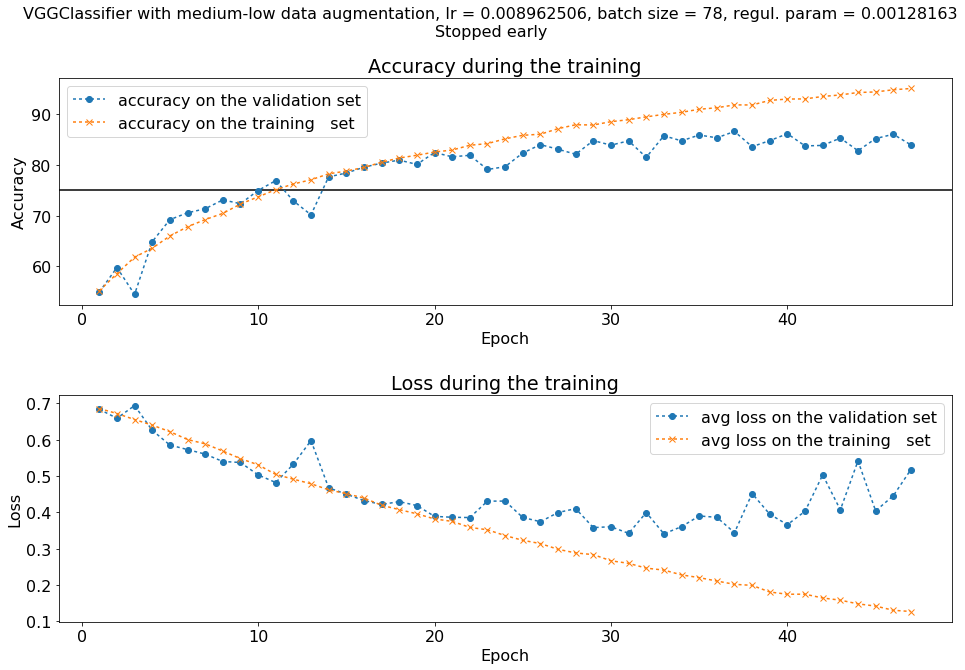

In [0]:
want_log       = False
early_stop     = True
early_stop_idx = 47
title        = "VGGClassifier with medium-low data augmentation, lr = {lr}, batch size = {bs}, regul. param = {rp}".format(
                    lr=lr,
                    bs=train_batch_size,
                    rp=regularization
                ) 
if early_stop :
    title += "\nStopped early"
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")

plot_1d_acc_and_loss(net1, accuracy1[:early_stop_idx,:], avg_loss1[:early_stop_idx,:], path_to_save, filename, title, want_log)

#### Plot the training error and validation error curves, along with the training and validation losses.   Comment  on  them.   
We display below what we add we we runned the notebook. We can see that for the training dataset both the loss and the error seem to be going to zero. Also, we can see that for some time both losses curves are close to one another until a point after which the validation loss goes through a plateau with random noise and eventually starts increasing. During that same period, the validation error does the same thing. The patience parameter was set to 11 epochs, i.e. after 11 epoch of no improvement in the validation accuracy (which peaked at epoch 37), the training ended at epoch 48. Epoch 37 was also where the validation loss reached its minimum. Because the state of the cnn at epoch 37 was saved, it could be retrieved.

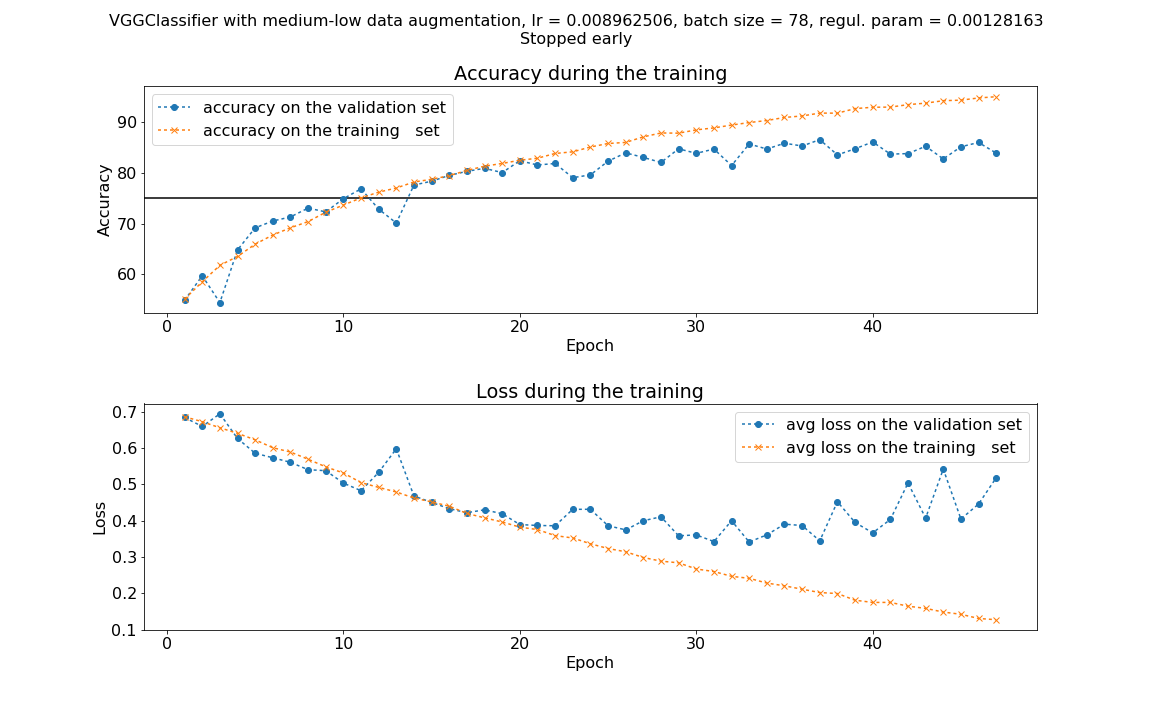

In [0]:
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February15_PM08H58M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# # Question 3: Finding good hyper-parameters

#### Search for the right model

We could considered the following two respects:

1.   Architectrual decisions: those that change the structure of the model and its programming structs such as the number of layers, the size of hidden layers, non-linearities for activations, kernel parameters (e.g., its size and stride), initialization method, etc.
2.   Tuning iteration hyper-parameters: which is usually done with grid search or random search
> *   mini-batch size
> *   learning rate

Between the two above, the architectrual decisions are more expensive to implement. Mindful of our recource limitation, we tried several architectures and comparing their validation errors brought, and we ended up choosing Classifier 5 over the rest.

As for the hyper-parameters search, we did not want to use grid search, because it amounts to search for too few point in each individual dimension. i.e. the cardinality of the projection of the points used in each dimension is significantly lower than the total number of points evaluated.   
In order to efficiently look for parameters, we opted for a low discrepency deterministic (so called quasi-random) sequence called sobol sequence that ensures a lower discrepancy than a true random (big holes in the resulting samples).

Here's what it looks like.  
We define one class that wrap a sobol sequence.

In [0]:
class HyperParameterSequence():
    """
    n-dimensional Sobol sequence :
        - starting_point : the point in the (infinite) sobol sequence at 
                           which our search will begin for reproductibility, 
                           this number has to be remembered
        - nb_points      : number of consecutive points of the sequence we 
                           use for evaluation
        - dim            : number of dimension of the search
        - c_interval     : list of lists each of the form [lower bound, upper 
                           bound] for each dimension
    """
    def __init__(self,starting_point,nb_points,dim,c_interval):
        self.starting_point = starting_point
        self.nb_points      = nb_points
        self.dim            = dim
        self.c_min = np.empty(self.dim)
        self.c_max = np.empty(self.dim)
        for i in range(self.dim) :
            self.c_min[i] = c_interval[i][0]
            self.c_max[i] = c_interval[i][1]
            
        self.seq = np.empty((nb_points,3))
        start = starting_point
        end   = start + nb_points
        for i,j in enumerate(range(start,end,1)) :
            hyperparam_point ,_ = sobol_seq.i4_sobol(self.dim,j)
            # take the point in the unitary cube and map it to the desired box
            for k in range(self.dim) :
                self.seq[i,k] = hyperparam_point[k]*(self.c_max[k]-self.c_min[k]) +self.c_min[k]
        
    def __len__(self):
        return self.nb_points
    
    def get_dim(self):
        return self.dim
    
    def get_interval(self,k):
        return self.c_min[k], self.c_max[k]
    
    def __getitem__(self, idx):
        return self.seq[idx]
    
    def get_sequence(self):
        return self.seq
    

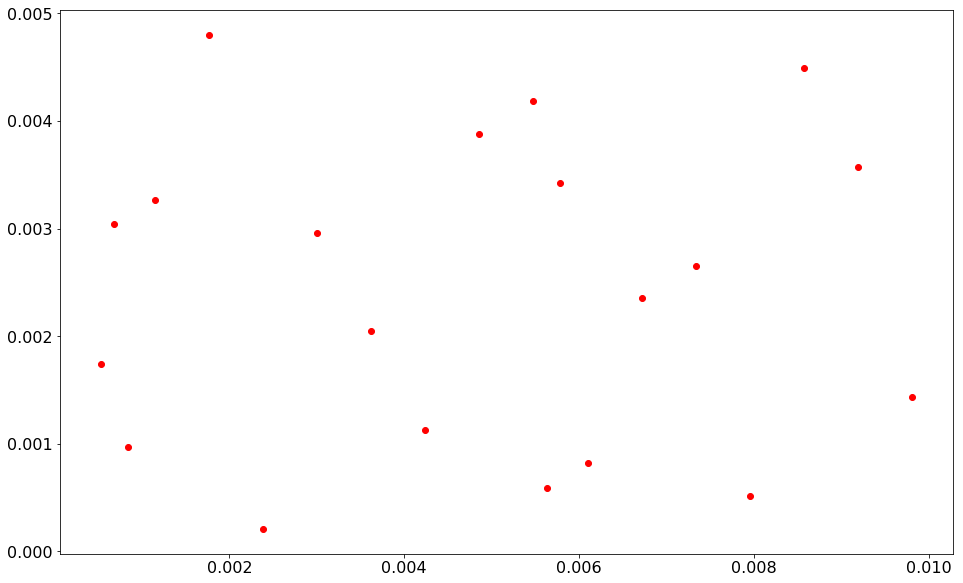

In [0]:
# Vizualize a 2d sobol sequence in the desired search box       
starting_point = 8030
nb_points      = 20
lr_interval    = [0.0001, 0.01]
re_interval    = [0.0001,0.005]
intervals      = [lr_interval, re_interval]
hyper_param_sequence = HyperParameterSequence(starting_point,nb_points,2,intervals)
seq = hyper_param_sequence.get_sequence()
plt.plot(seq[:,0],seq[:,1], 'ro')
plt.show()

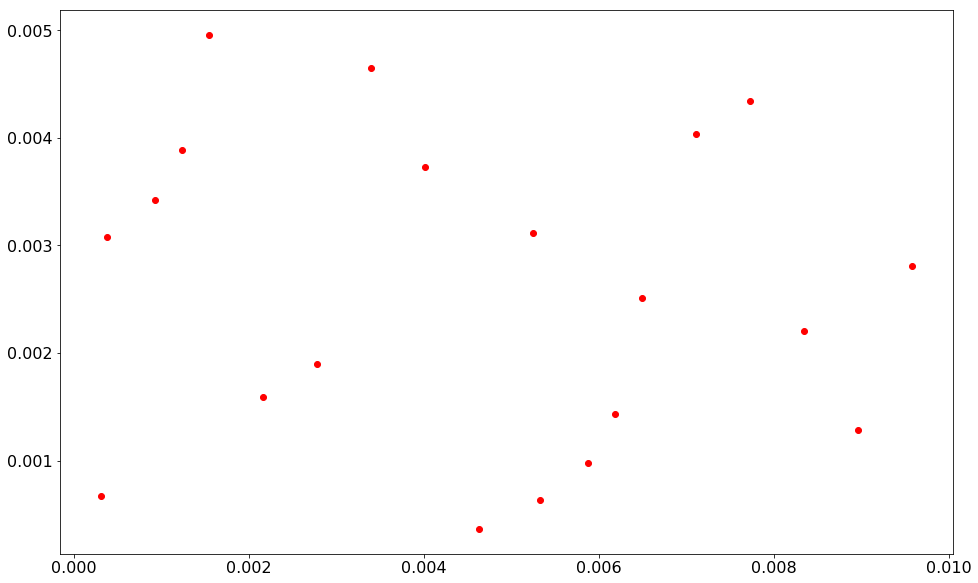

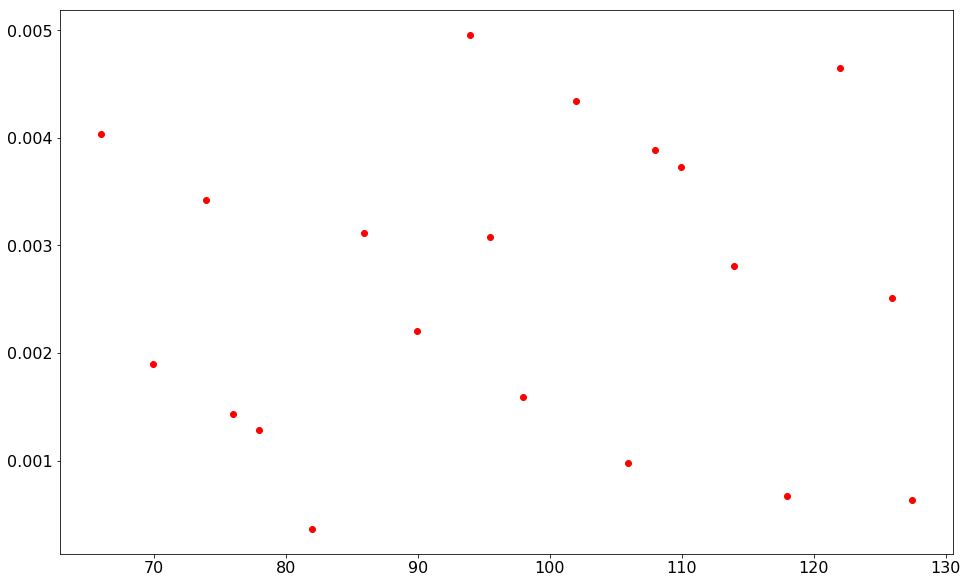

In [0]:
# Vizualize 2 dimension hyper-planes of a 3d sobol sequence 
starting_point = 10030
nb_points      = 20
lr_interval    = [0.0001, 0.01]
bs_interval    = [1*64,2*64]    # warning : if this is set too high, you can encounted a Runtime Error: CUDA out of memory 
re_interval    = [0.0001,0.005]
intervals      = [lr_interval, bs_interval, re_interval]
hyper_param_sequence = HyperParameterSequence(starting_point,nb_points,3,intervals)
seq = hyper_param_sequence.get_sequence()
plt.plot(seq[:,0],seq[:,2], 'ro')
plt.show()
plt.plot(seq[:,1],seq[:,2], 'ro')
plt.show()

#### What we plan to do :  
To find the most promising combination of learning rates, we use the following pseudocode:

#### Pseudocode
1.   We generate a point in hyper-parameter space   
2.   We train an net for k epoch using these hyper-parameters  
3.   We pick the net that has the highest accuracy on the validation dataset  
4.   Continue training this net with the same fixed hyper-parameters

#### Searching hyper-parameters space in 3 dimensions :  
- learning rate  
- batch size  
- regularisation parameter  

In [0]:
nb_epoch  = 3
patience  = 2

# current state with the best performance on the validation set, on its last epoch
acc_max = 0
idx_max = 0

# we save (all) the intermediate state of the model during the learning phase
state_dict_dict = dict() 
valid_batch_size = 4*64
valid_loader = DataLoader(train_dataset_norm, batch_size=valid_batch_size,sampler=valid_sampler, num_workers=num_workers)
for i, hyperparam_point in enumerate(hyper_param_sequence):  
    lr         = hyperparam_point[0]
    batch_size = math.ceil(hyperparam_point[1]) # cast to the correct type
    regul      = hyperparam_point[2]
    net_tmp = VGGClassifier() 
    net_tmp.apply( glorot_init )
    _ = net_tmp.to(device)
    
    criterion = nn.CrossEntropyLoss(reduction='sum')
    optimizer = optim.SGD(net_tmp.parameters(), lr=lr, momentum=0.0, weight_decay=0)
    
    train_loader = DataLoader(train_dataset_augm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
    state_dict_list_tmp = list() # we save (all) the intermediate state of the model during the learning phase, for one  mlp

    # average loss across epoch
    avg_loss_tmp     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    # accuracy[i, 0 (resp. 1)] is the training (reps. validation) accuracy of the net at epoch i
    accuracy_tmp     = torch.empty(nb_epoch,2, dtype=torch.float, device = device)
    
    # print hyper-parameters 
    print("point no. {i}, lr = {lr}, batch size = {batch_size}, regul={regul}".format(
                i=i, 
                lr=lr,
                batch_size=batch_size,
                regul=regul
        ))
    
    # we dump output to disable sound
    torch.cuda.synchronize()
    _ = training_phase( net_tmp, nb_epoch, optimizer, regul, patience, avg_loss_tmp, 
                           accuracy_tmp, train_loader, valid_loader, state_dict_list_tmp )
    state_dict_dict[i] = [[lr,batch_size,regul],state_dict_list_tmp,avg_loss_tmp,accuracy_tmp]
    
    
    valid_accuracy = accuracy_tmp[-1,1] # last validation accuracy
    if valid_accuracy > acc_max :
        acc_max = valid_accuracy
        idx_max = i
    torch.cuda.synchronize()

print("#####################")
print("best net found : {i} , with validation accuracy = {va}".format(i=idx_max,va=acc_max.item()))
if want_lound_warning :
    Audio(wave, rate=10000, autoplay=True)

point no. 0, lr = 0.006178131103515626, batch size = 76, regul=0.001434759521484375
epoch =   1, train loss = 0.685866 , train accuracy = 54.664146 , valid loss = 0.674845 , valid accuracy = 59.629814
epoch =   2, train loss = 0.672871 , train accuracy = 58.781044 , valid loss = 0.679346 , valid accuracy = 56.528263
epoch =   3, train loss = 0.659360 , train accuracy = 61.258961 , valid loss = 0.662868 , valid accuracy = 59.479740
Finished Training
Time required =  502.1490625  s 
point no. 1, lr = 0.001228131103515625, batch size = 108, regul=0.0038847595214843746
epoch =   1, train loss = 0.690818 , train accuracy = 54.180786 , valid loss = 0.689068 , valid accuracy = 56.028015
epoch =   2, train loss = 0.686327 , train accuracy = 57.325405 , valid loss = 0.686039 , valid accuracy = 54.627316
epoch =   3, train loss = 0.681139 , train accuracy = 58.175453 , valid loss = 0.680879 , valid accuracy = 55.727863
Finished Training
Time required =  180.66470312500002  s 
point no. 2, lr = 0

point no. 17, lr = 0.000300006103515625, batch size = 118, regul=0.000669134521484375
epoch =   1, train loss = 0.693041 , train accuracy = 51.486195 , valid loss = 0.692249 , valid accuracy = 54.177090
epoch =   2, train loss = 0.691775 , train accuracy = 55.030834 , valid loss = 0.691789 , valid accuracy = 51.775887
epoch =   3, train loss = 0.691060 , train accuracy = 53.930775 , valid loss = 0.691050 , valid accuracy = 53.426712
Finished Training
Time required =  299.41390625  s 
point no. 18, lr = 0.000377349853515625, batch size = 96, regul=0.0030808532714843746
epoch =   1, train loss = 0.692339 , train accuracy = 52.419579 , valid loss = 0.691695 , valid accuracy = 51.625813
epoch =   2, train loss = 0.690665 , train accuracy = 54.308571 , valid loss = 0.690459 , valid accuracy = 53.776890
epoch =   3, train loss = 0.689216 , train accuracy = 56.569809 , valid loss = 0.689074 , valid accuracy = 56.128063
Finished Training
Time required =  601.55975  s 
point no. 19, lr = 0.0053

### Display the result of the search  

In the following plot, the bigger the area of the point, the higher is the accuracy of the model corresponding to its coordinated hyperparameters.

<font color='red'> Big points are good, small points are bad.  
We scale the area of the points to make the results easily understandable.  </font>

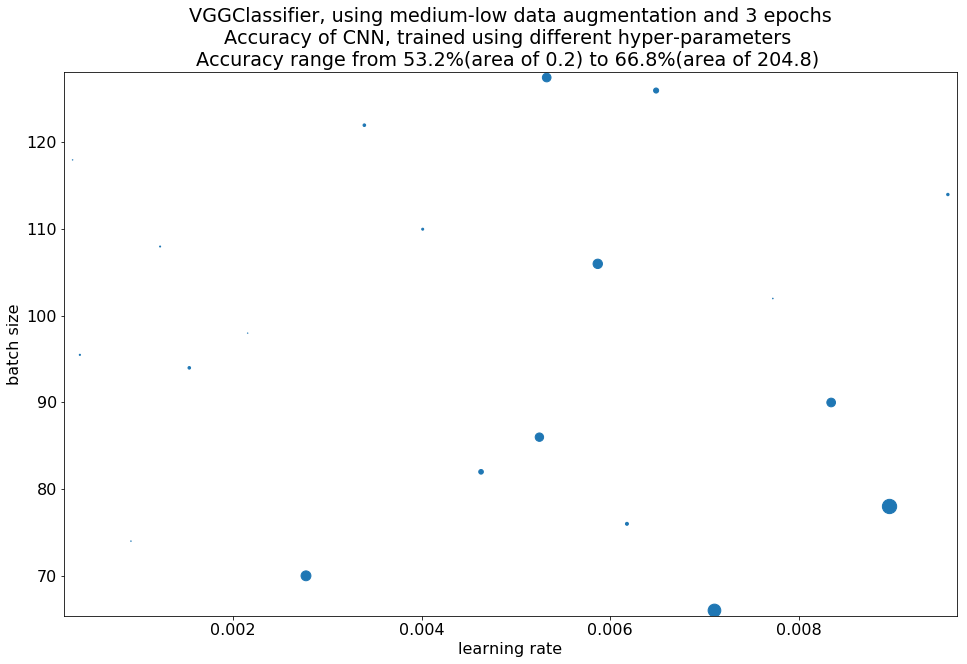

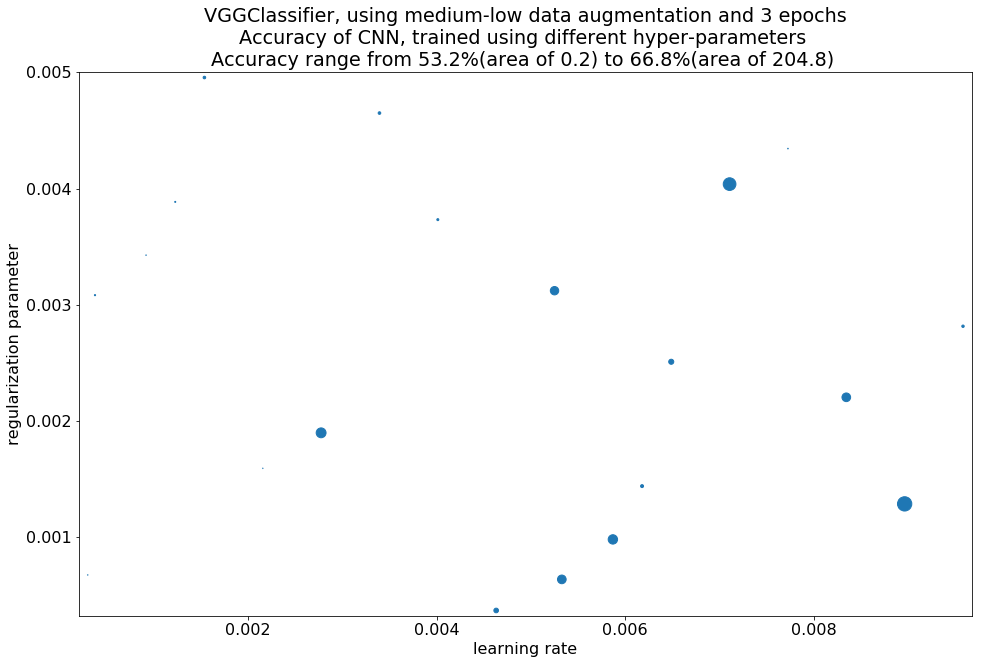

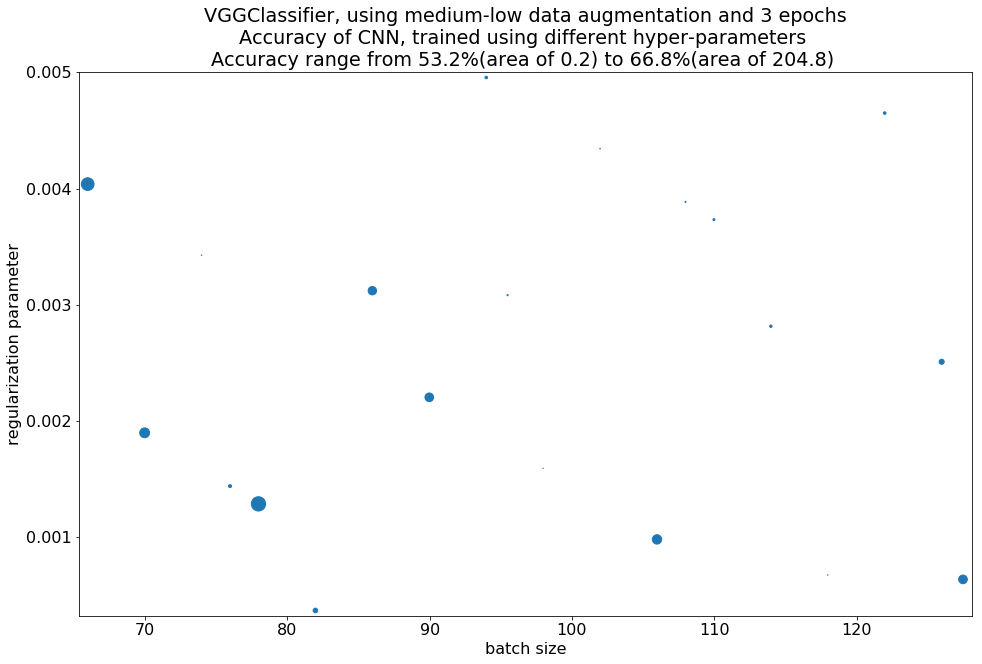

In [0]:
want_log     = True
path_to_save = "./output/" 
filename     = datetime.datetime.now().strftime("%Y%B%d_%p%IH%MM")
title        = "VGGClassifier, using medium-low data augmentation and 3 epochs"

# retrieve the sequence used for the search  
hyper_param  = hyper_param_sequence.get_sequence()  
N            = hyper_param_sequence.__len__()

# define hyper-planes to display
hyper_param_plane = np.empty((3,N,2))
hyper_param_plane[0] = hyper_param[:,[0,1]]
hyper_param_plane[1] = hyper_param[:,[0,2]]
hyper_param_plane[2] = hyper_param[:,[1,2]]
axis_label   = [
        ("learning rate","batch size"),
        ("learning rate","regularization parameter"),
        ("batch size","regularization parameter")
    ]
_val = np.empty(N)
# retrieve previously measured accuracy 
for i in range(N):
    # [lr,batch_size],state_dict_list_tmp,avg_loss_tmp,accuracy_tmp
    _,_,_,acc = state_dict_dict[i]
    _val[i]   = acc[-1,1]  

for k in range(3):
    plot_accuracy_2d(_val,hyper_param_plane[k],path_to_save,filename + "{k}".format(k=k),
                     title,axis_label[k],want_log,scaling=(0.2,10))

# Our results    
This next section is composed of a list of plots in group of two:  
- The first  shows the result of the search in the hyper-parameter space  
- The second shows the result of taking those hyper-parameters and training a model with them  
  
The discussion comes after the plots.

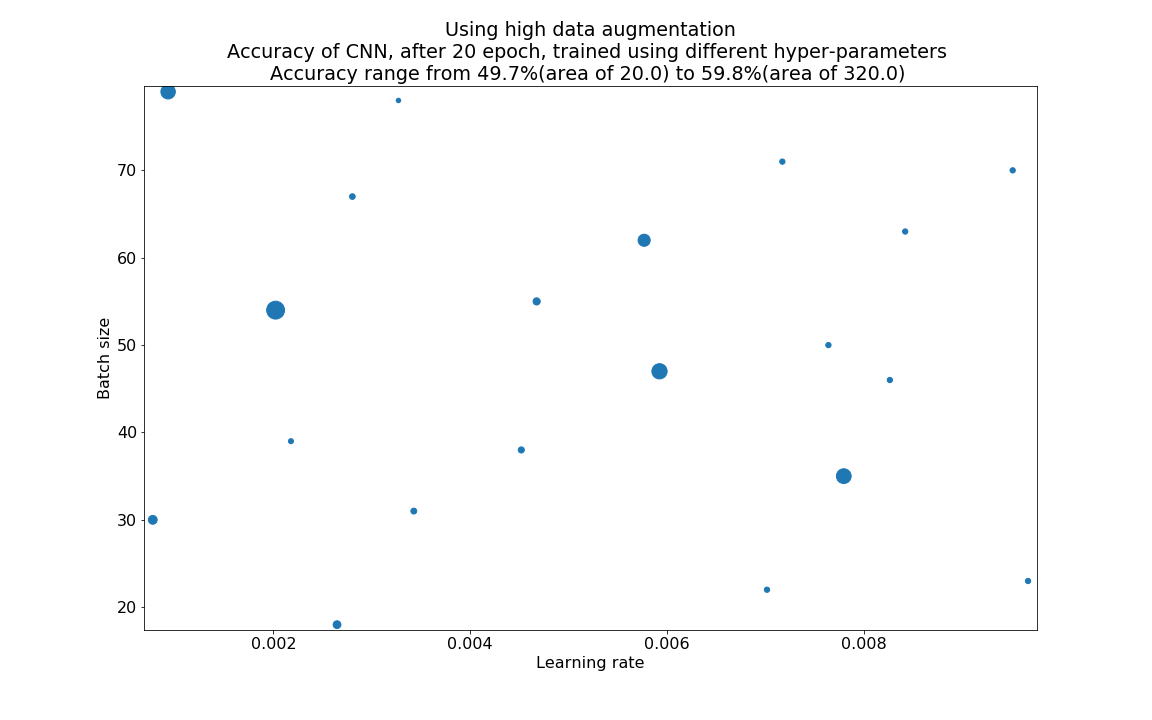

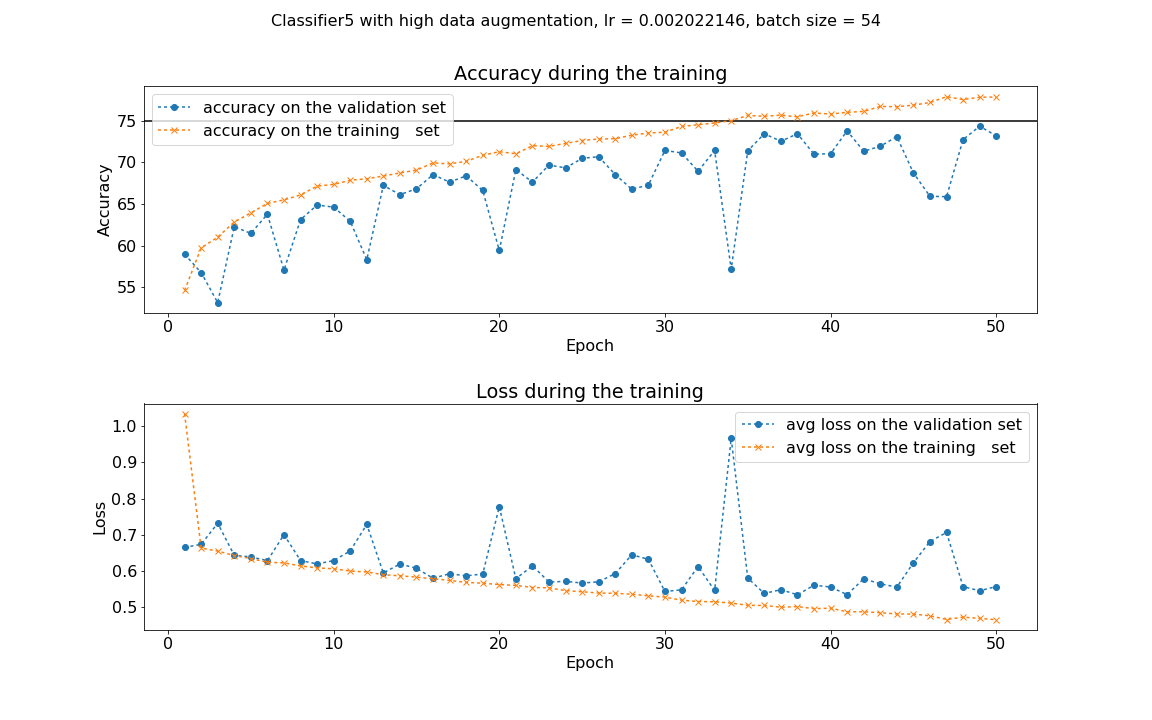

In [0]:
# Here's what we add when we runned the notebook with high data augmentation :
# and :
# starting_point = 4030
# nb_points      = 20
# lr_interval    = [0.01,0.00001]
# bs_interval    = [16,80] 
# using high data augmentation we found lr = 0.002022, batch size = 54
loading_path = "./output/2019February14_AM12H32M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
# Here's what we add when we runned the notebook :
loading_path = "./output/2019February14_AM01H03M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

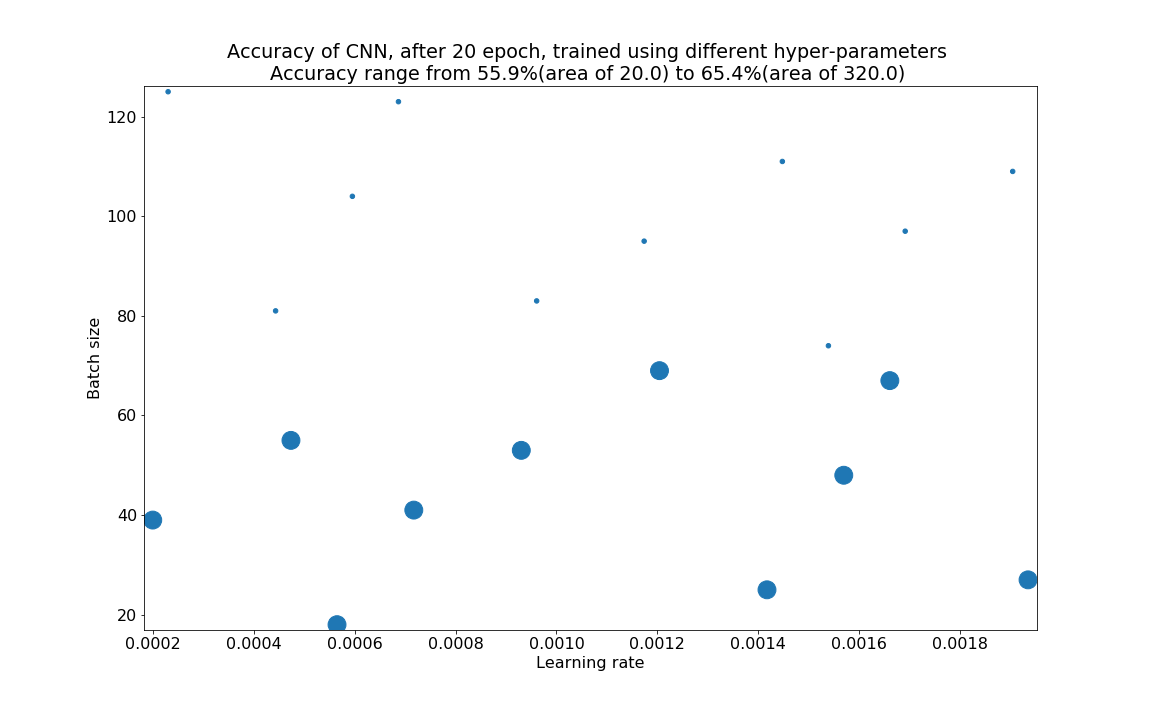

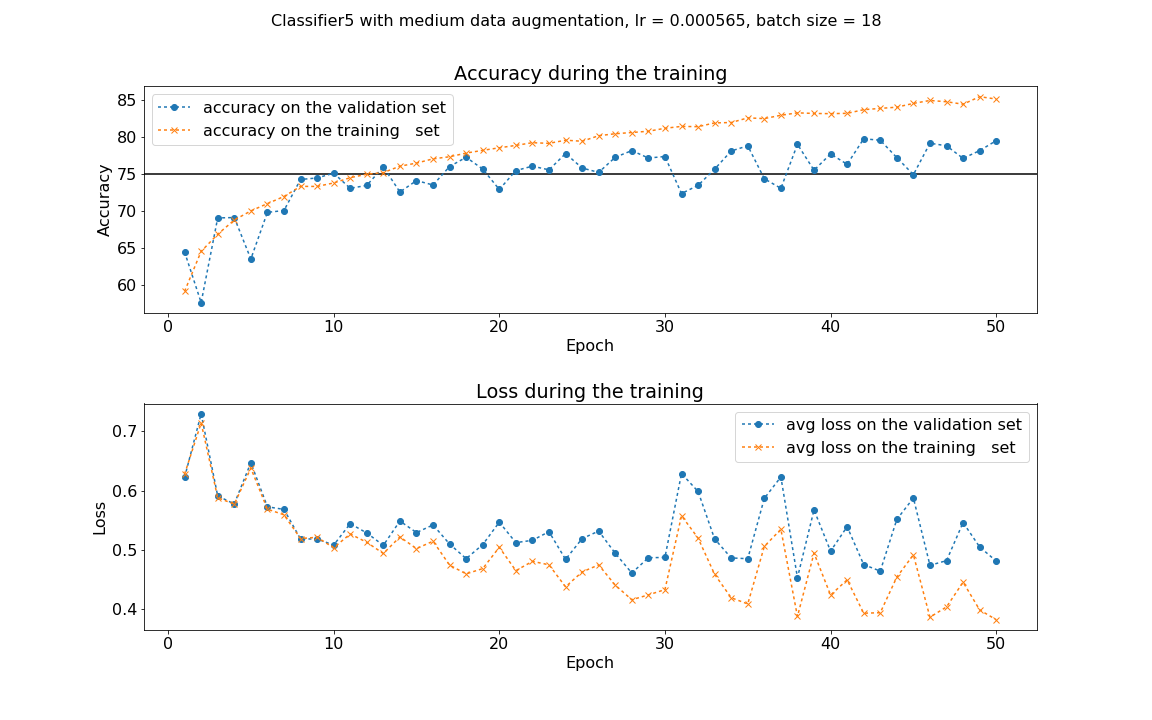

In [0]:
# Here's what we add when we runned the notebook with medium data augmentation :
# and :
# starting_point = 3030
# nb_points      = 20
# lr_interval    = [0.002,0.00005]
# bs_interval    = [16,2*64]
# using Classifier5, no regularization and medium  data augmentation : 
# lr = 0.0005646362304687499, batch size = 18
loading_path = "./output/2019February13_PM10H33M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/2019February13_PM11H49M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

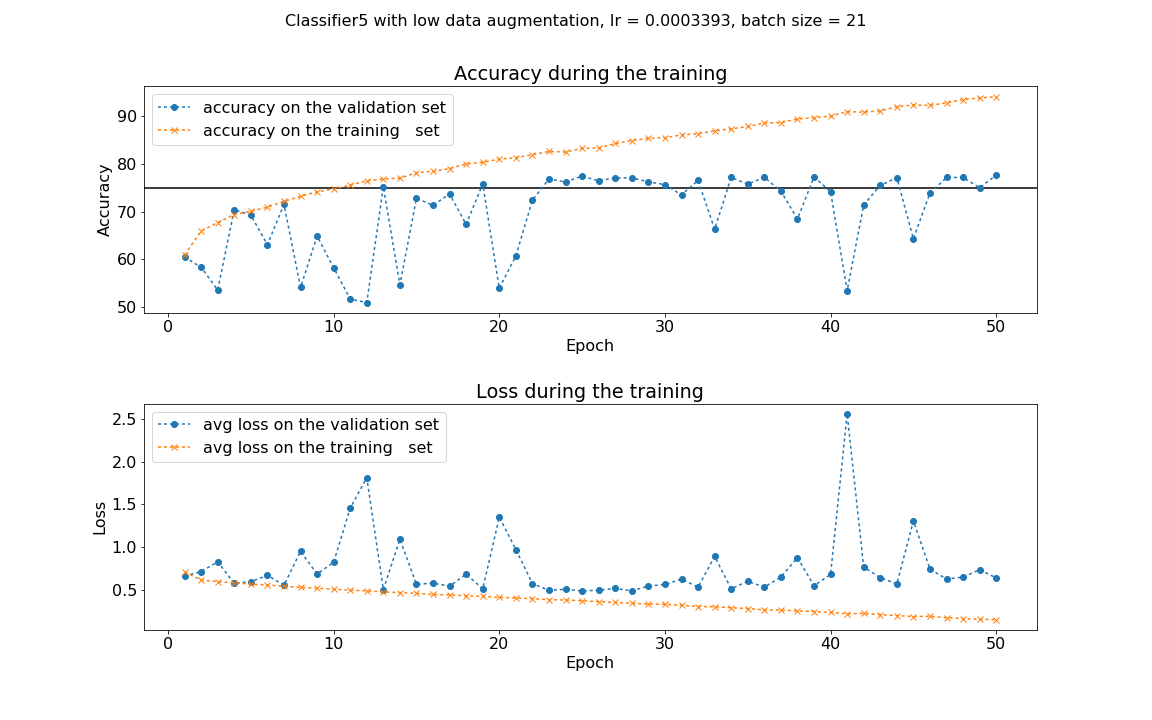

In [0]:
# Here's what we add when we runned the notebook with low data augmentation :
# and :
# starting_point = 2030
# nb_points      = 20
# lr_interval    = [0.00001,0.01]
# bs_interval    = [16,64]
# using Classifier5, no regularization and low data augmentation : 
# lr = 0.0003392602539062500, batch size = 21
loading_path = "./output/2019February14_PM01H40M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

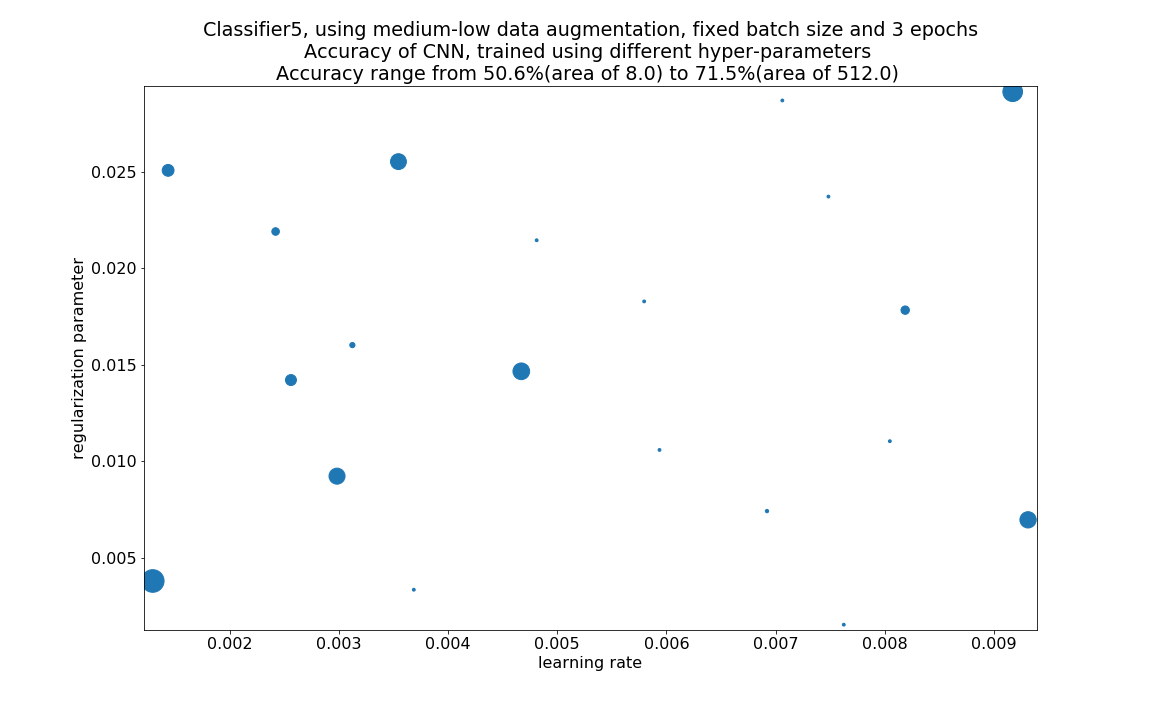

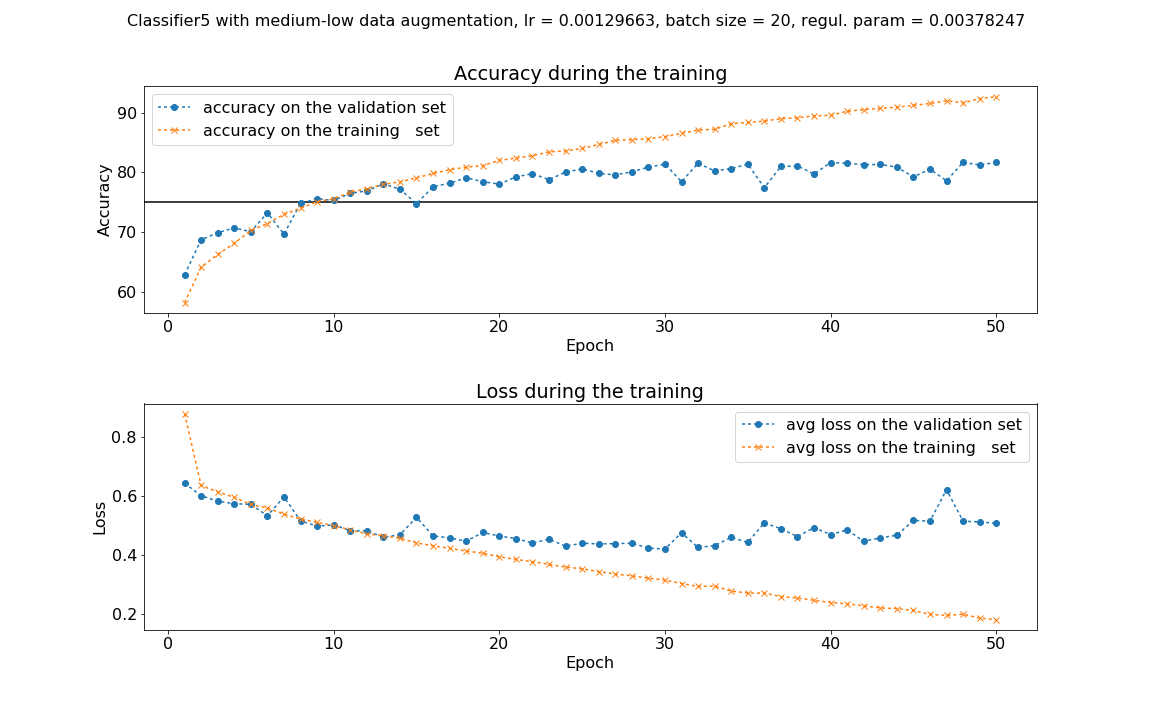

In [0]:
# Here's what we add when we runned the notebook with medium-low data augmentation :
# and :
# starting_point = 2030
# nb_points      = 20
# lr_interval    = [0.0001,0.01]
# re_interval    = [0.0001,0.03]
# bs_interval    = [20,20]
# using Classifier5, regularization and medium-low data augmentation :
# lr = 0.00129663, batch size = 20, regul = 0.00378247 
loading_path = "./output/2019February14_PM10H18M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/2019February14_PM11H48M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

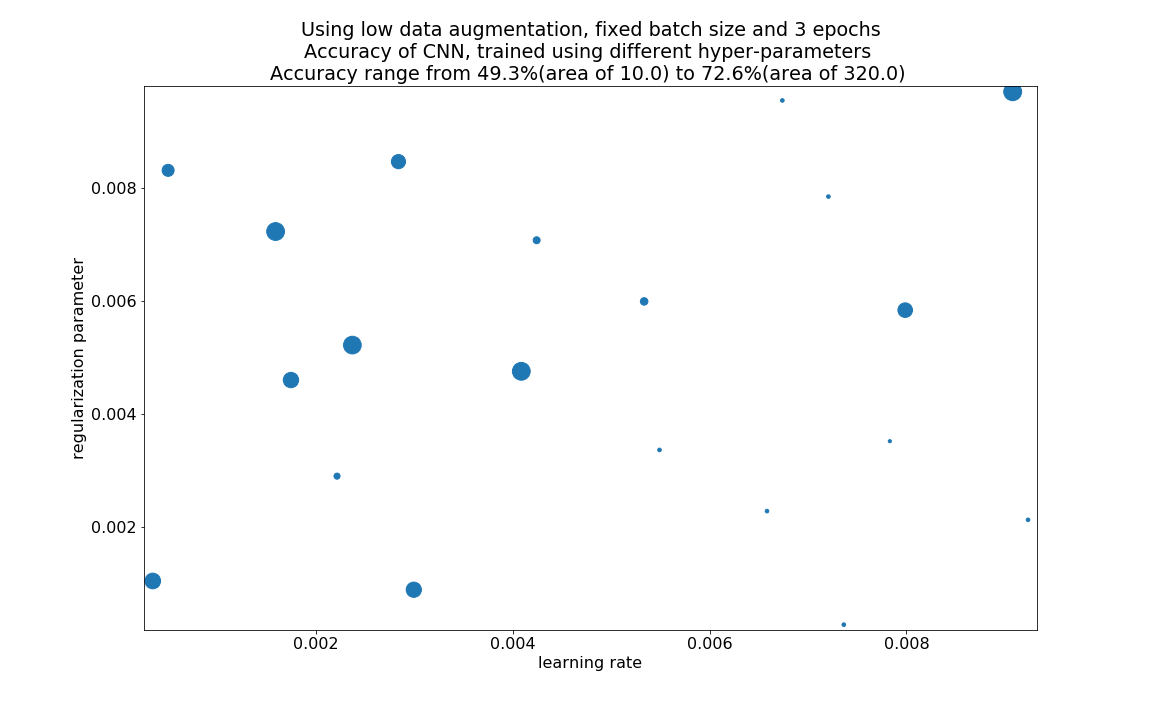

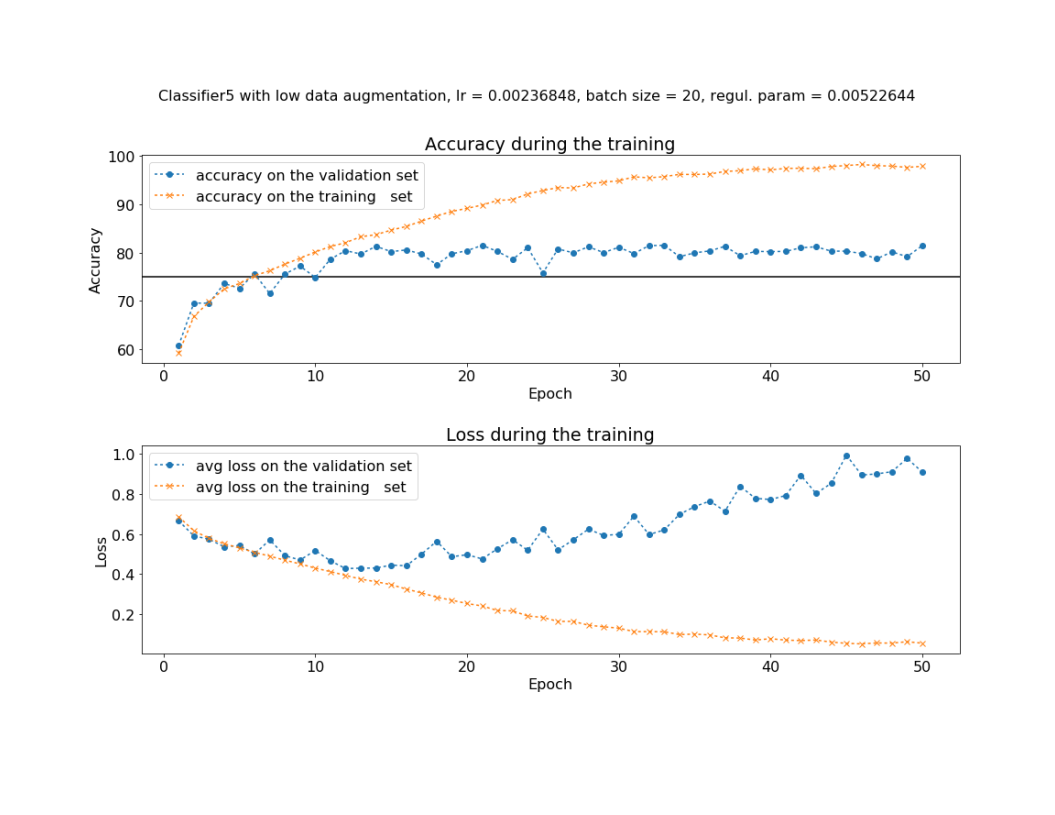

In [0]:
# Here's what we add when we runned the notebook with low data augmentation :
# and :
# starting_point = 5030
# nb_points      = 20
# lr_interval    = [0.00001,0.01]
# re_interval    = [0.0001,0.01]
# bs_interval    = [16,64]
# using Classifier5, no regularization and low data augmentation : 
# lr = 0.00236848, batch size = 20, regul = 0.00522644 
# lr = 0.0003392602539062500, batch size = 21
loading_path = "./output/2019February14_PM03H35M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/2019February14_PM05H01M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

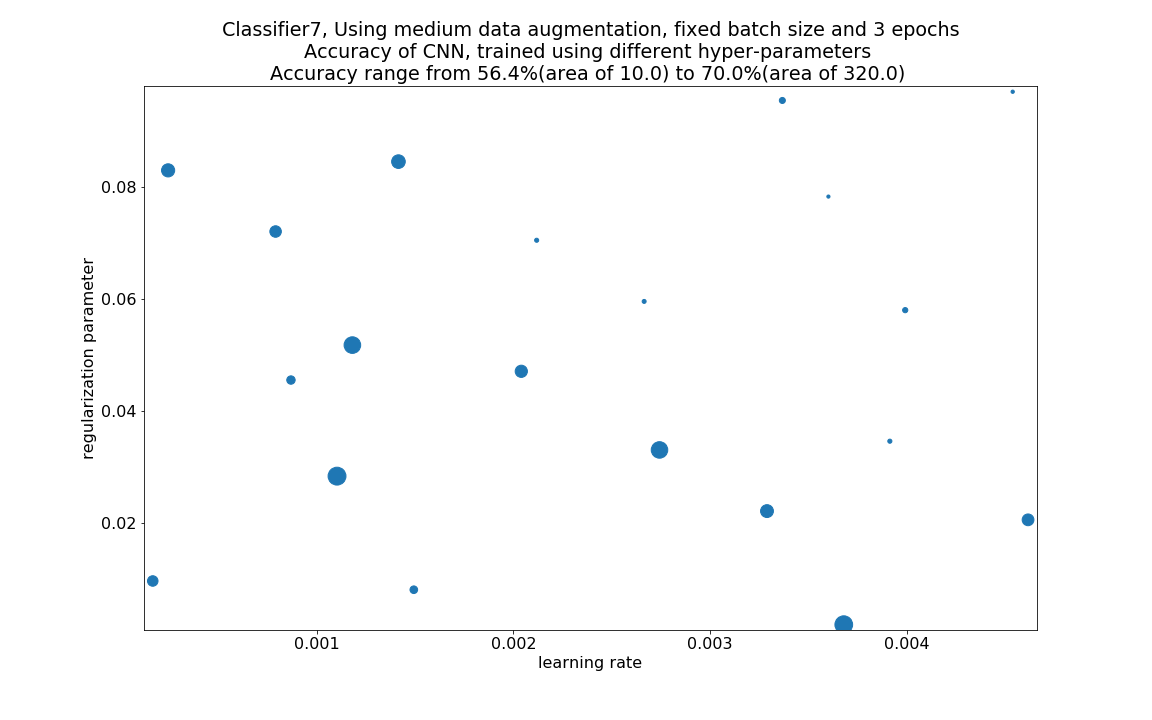

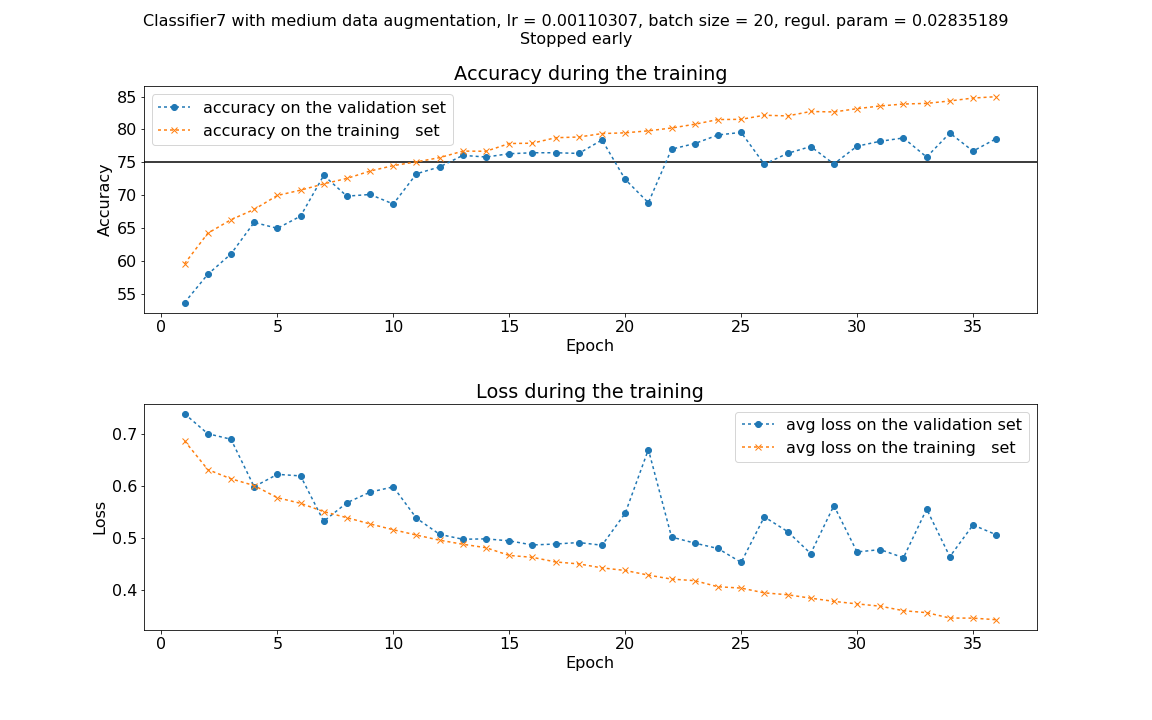

In [0]:
# Here's what we add when we runned the notebook with Classifier7 
# and medium data augmentation :
# starting_point = 6030
# nb_points      = 20
# lr_interval    = [0.000001,0.005]
# re_interval    = [0.00001,0.1]
# bs_interval    = 20
# using Classifier7, regularisation and medium data augmentation : 
# lr = 0.00110307, batch size = 20, regul = 0.02835189 
loading_path = "./output/2019February14_PM08H43M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/2019February14_PM09H17M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

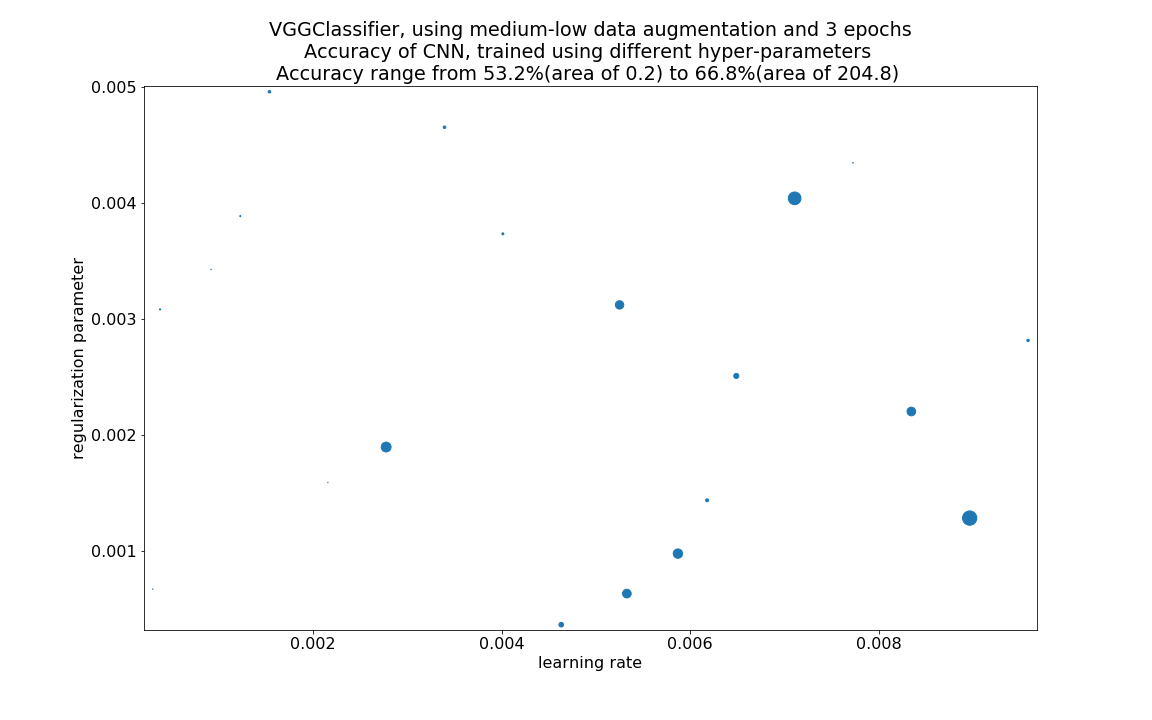

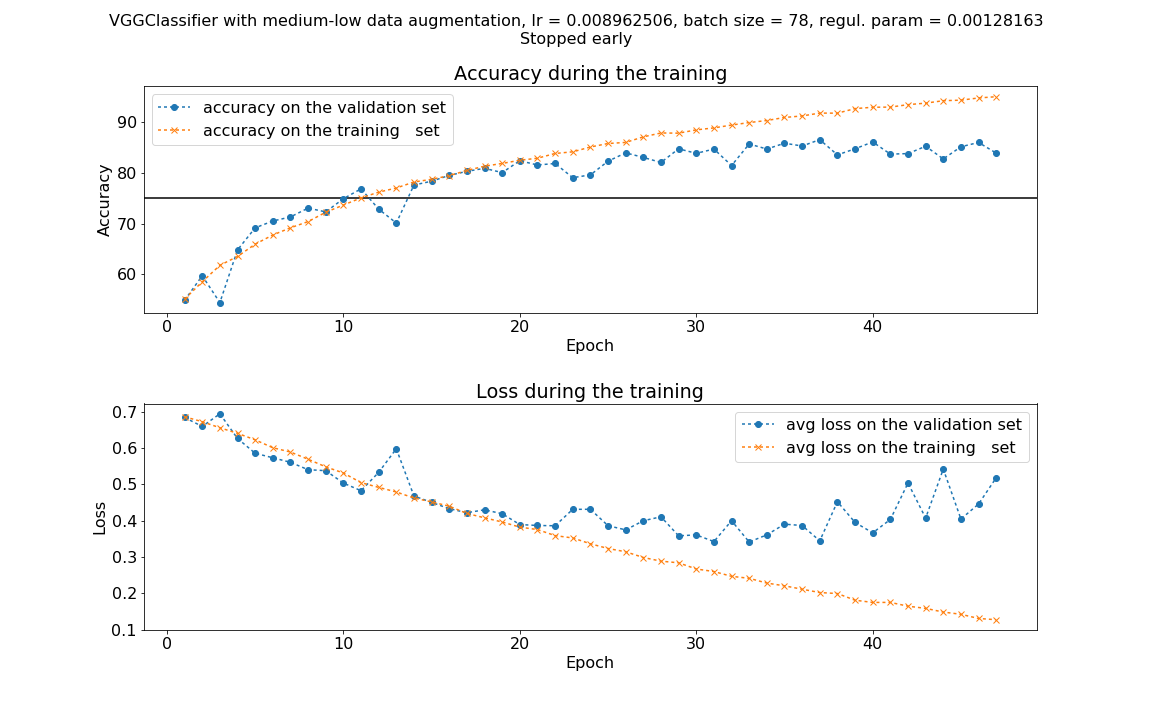

In [0]:
# Here's what we add when we runned the notebook with VGGClassifier 
# and medium-low data augmentation :
# starting_point = 10030
# nb_points      = 20
# lr_interval    = [0.0001, 0.01]
# bs_interval    = [  1*64, 2*64]   
# re_interval    = [0.0001,0.005]
# using VGGClassifier, regularisation, using med-low data augmentation we found :
# lr = 0.008962506103515625 , batch size = 78, regul = 0.00128163
# these 3 plots each represent a different hyper-plane of the search
# loading_path = "./output/2019February15_PM10H53M0.png"
loading_path = "./output/2019February15_PM10H53M1.png"
# loading_path = "./output/2019February15_PM10H53M2.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
# the minimum loss on the validation dataset is at epoch 34
loading_path = "./output/2019February15_PM08H58M.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

# Question 2 and 3 (Cont'd): Our interpretation  

#### Compare different hyperparameter settings  

The best type of data augmentation was determined using the Classifier5 model (with ~2 millions params). In order to be able to find what type of data augmentation works best, we had to settle to make the search using a 'small-but-not-too-small' model and stop at epoch 50. We could not afford to make the search using a very large model (i.e. VGGClassifier). 

The plots show that the best performance (without regularization) was found with medium data augmentation. Higher than that, the net had not enough capacity to learn with the training dataset and was learning slowly. Lower than that, the net was quickly reaching a good accuracy on the training dataset and was overfitting.  

So, we decided to implement L2-regularization and compare low and medium-low data augmentation. L2-Regularization improved the model performance by reducing the gap between training and validation dataset accuracy. Also, the gap between training and validation dataset accuracy was found reduced the most using medium-low data augmentation.  

Then, we tried to use medium data augmentation with a bigger model : Classifier7 which has ~6 millions params. We wanted to see if its larger capacity would enable it to overfit the training dataset. The answer was negative so we concluded that medium data augmentation was making the learning task too difficult and we had to settle for a milder augmentation intensity for the next big run. Medium-low data augmentation was our best candidate.  

The default VGGClassifier model (defined above) has ~13millions parameters. We picked a good combinason of hyper-parameters for it using the same search method as before. Then, we trained it with those hyper-parameters until it early stopped at epoch 47. We had saved its state at each epoch of the training and we loaded the state that was both minimizing average loss and close-to-maximizing accuracy for the validation dataset. The plots show that this model achieved the best accuracy over the validation dataset.  

Also, the plots displaying the hyper-parameters search results nearly all show that the hyper-parameters that performed the best were surrounded by similary good performing hyper-parameters and that the hyper-parameters farther performed significantly worse. This gave us confidence that the hyper-parameters we picked were good choices.  

#### Report the final results of performance on your validation set  :

Our final results are : 
- training dataset accuracy   = 91.28 %   
- validation dataset accuracy = 85.34 %   

With the following 95% confidence interval (c.i.) for the probability of finding the good label on the validation dataset 
(83.71%, 86.86%). The computation of this c.i. was explained earlier on the notebook. Seeing the gap between the two datasets accuracy indicates that we have to expect a lower accuracy on the test dataset. Especially since the model used for submission to kaggle was retrieved because of its good performance on the validation dataset.

#### How does your validation performance compare to the test set performance (that you can only get in Kaggle)   

On kaggle, we obtained 86.514% accuracy on the test set upon submission and now that the competion has completed we have 84.84%. This is numerically very close to the validation dataset accuracy and both values fall inside the 95% confidence interval for the probability of finding the good label on the validation dataset. This means that our methodology (way of chosing hyper-parameters + training + early stopping + retrieving the state that minimized loss on the valitation dataset) was such that there is not a statistically significant gap in the performance of the trained cnn at the end between the validation and testing dataset. i.e. it cannot be discarded that the accuracy our cnn achieve on the validation dataset represents the accuracy it will achieve on a dataset taken from the same distribution and not yet seen from him.  

#### What  techniques  (you  did  not  implement)  could  be  useful  to improve the validation performance.    

There are different techniques that are useful to explore further to improve the performance of the model.

**Initialization:**  All of our trainings started off from random glorot initialization. Techniques such as batch normalization and transfer learning are proven very helpful in the literature and ImageNet competitions. They both help signifanctly with initializing neural network models.

**Hyper-parameter search:** As for finding the efficient hyper-parameter we are left with a prior knowledge that say learning rate should be small . One more systematic approach towards would be bayesian optimization to select most informative hyper-parameters to run. The disadvantage of this approach is that it introduces other hyper-parameters to tune gaussian processes.

  **Optimizing Error:** In order to avoid overfitting we used data augmentation, L2 regularizations, and early stopping approach while dropout (manual chap 7.12) one of the most effective mechanism to improve generalizability remained untested (reducing the gap between training and validation error). Moreover, more learning acceleration tools that were left out such as Momentum, learning rate scheduling, and Adam. And, lastly,  paraphrasing from Aaron, "sometimes learning learning from classification error itself is more effective that learning the surrogate error (the negative likelihood error)". So, it would have been a great idea if we could afford to try learning the classification error itself to have a comparison how well it can be. Precision could be another limit to push, both on where to reduce to improve acceleration and where to increase to improve the accuracy of the computations.

**Learning Capacity:** Starting from one layer, we were on the trend of deepening the model more and more for better validation error. Interesting enough, there are some studies in favor of deepening models without incurring bias error/overfitting. However, usually this comes with a caveat of possibility of suffering backpropagation flow. Using ReLU is aptly helps in these scenarios compared to exponential non-linearities. There are also models such as ResNet that introduced skip connections which certainly open a potential exploration area.


# Miscellaneous   
#### Aside from quantitative results, also include some visual analysis such as :
- visualizing the feature maps or kernels, or  
- showing examples where the images are :
    - (a) clearly misclassified and  
    - (b) where the classifier predicts around 50% on both classes. 
    
#### Explain your observation and/or suggest any improvements you think may help  

### Answer  
In order to measure the model's performance we run the model on the validation set again and measure how confident (at what probability) the model predicts correctly or misclassifies.

In [0]:
# For this part, you can load an already trained model :

# loading_path = "./save/export/dev1num3Classifier5_82.pth"    # Classifier5() with 82% accuracy
# cudanet_tocpu = Classifier5() 

# loading_path = "./save/export/dev1num3VGGClassifier_86.pth"  # VGGClassifier() with 86% accuracy
loading_path = "./save/export/dev1num3VGGClassifier5_85.pth"  # VGGClassifier() with 85% accuracy
cudanet_tocpu = VGGClassifier() 

cudanet_tocpu.load_state_dict(torch.load(loading_path))
mynet = copy.deepcopy( cudanet_tocpu ).to(device)

In [0]:
# For this part, the neural network should be called : mynet
_ = mynet.to(device)

In [0]:
# set the number of pictures to display
max_nb_to_display = 32

worst_false_  = []
best_false_   = []
best_correct_ = []
positivehisto = [[],[]] # remember separately for cat (index 0) and dog
negativehisto = [[],[]] #
from heapq import *

# class storing 3 elements, using only the first for comparison
class CostAndValue:
    def __init__(self, cost, img, label):
        self.cost  = cost
        self.img   = img
        self.label = label

    # do not compare values
    def __lt__(self, other):
        return self.cost < other.cost
    
    def get_cost_and_value(self) :
        return self.cost, self.img, self.label  
    
# 
def class_from_index(ind):
    return train_dataset_norm.classes[ind]

def confidence(proba):
    pred = torch.softmax(proba,dim=-1)
    return (pred.max(1)[0] / pred.sum(1), pred.max(1)[1])

valid_batch_size=4*64
valid_loader = DataLoader(train_dataset_norm, batch_size=valid_batch_size,sampler=valid_sampler, num_workers=num_workers)

with torch.no_grad() :
    for img, lab in valid_loader:
        img = img.to(device)
        lab = lab.to(device)
        proba = mynet(img)
        confid, pred = confidence(proba)
        for i in range(img.size(0)) :
            img    = img.cpu()
            lab    = lab .cpu()
            confid = confid.cpu()
            pred   = pred.cpu()
                
            img_ = img[i]
            c    = confid[i].detach().item()
            lab_ = lab[i].item()
            if pred[i] != lab[i]:
                elem1 = CostAndValue(c,img_,lab_)
                elem2 = CostAndValue(-c,img_,lab_)
                if len(worst_false) > max_nb_to_display :
                    _ = heappushpop(best_false_ ,elem1)
                    _ = heappushpop(worst_false_,elem2)
                else:
                    heappush(best_false_ ,elem1) 
                    heappush(worst_false_,elem2) 
                negativehisto[lab_].append(c)
            else:
                elem = CostAndValue(-c,img_,lab_)
                if len(best_correct) > max_nb_to_display : # all end up having more confidence than 0.99999
                    _ = heappushpop(best_correct_,elem)
                else:
                    heappush(best_correct_,elem) 
                positivehisto[lab_].append(c)

worst_false  = []
best_false   = []
best_correct = []

for i in range(max_nb_to_display) :
    worst_false.append(worst_false_[i].get_cost_and_value())
    best_false.append(best_false_[i].get_cost_and_value())
    best_correct.append(best_correct_[i].get_cost_and_value())

Now by plotting the top k=32 most and least confident prediction we can see that the (right) ones with highest probability are the ones where the animal is looking directly at the camera and create a more defined face parts whereas the ones that are both highly doubted and misclassified by the model have less color contrast on their faces or with the background.

We also see that the misclassified pictures nearly all have more complex background and/or are more ambigious (with human standard) than the ones that were correctly classified. This could indicate that those picture are genuinely tougher to classify and that it would be a good thing to train on a dataset that contains more pictures of animal with complex background.

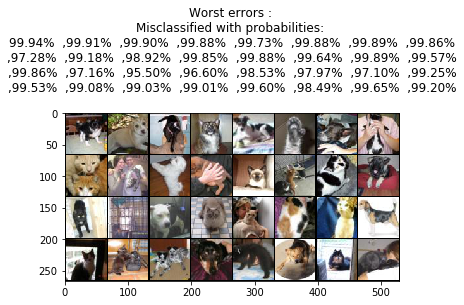

The correct labels were : 

 Dog   ,Dog   ,Cat   ,Dog   ,Dog   ,Cat   ,Dog   ,Cat 
,Cat   ,Cat   ,Dog   ,Dog   ,Cat   ,Cat   ,Cat   ,Dog 
,Cat   ,Cat   ,Dog   ,Cat   ,Cat   ,Cat   ,Cat   ,Dog 
,Cat   ,Cat   ,Dog   ,Dog   ,Dog   ,Dog   ,Dog   ,Dog 



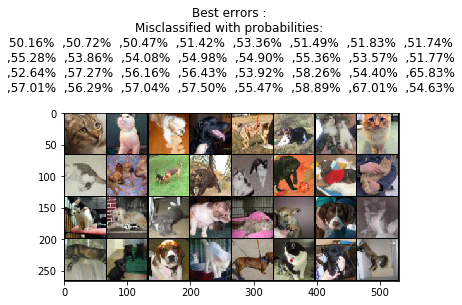

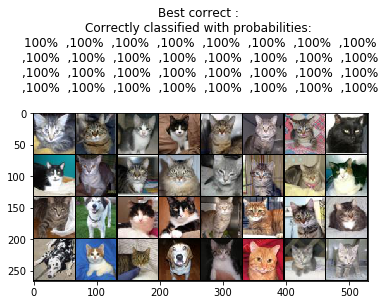

In [0]:
def imshow(img):
    npimg = img.numpy()  / 255
    # npimg = img.numpy() 
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

plt.title('Worst errors : \nMisclassified with probabilities: \n'+ ",".join(["{c:.2f}%{end}".format(c=-100*c,end="\n" if i%8==0 else "  ") for i,(c,img,lab) in enumerate(worst_false,1)]))
imshow( torchvision.utils.make_grid([img.squeeze() for c,img,lab in worst_false]) )

print("The correct labels were : \n")
print( " " + ",".join(["{lab} {end}".format(lab=class_from_index(lab),end="\n" if i%8==0 else "  ") for i,(c,img,lab) in enumerate(worst_false,1)]))

plt.title('Best errors : \nMisclassified with probabilities: \n'+ ",".join(["{c:.2f}%{end}".format(c=100*c,end="\n" if i%8==0 else "  ") for i,(c,img,lab) in enumerate(best_false,1)]))
imshow( torchvision.utils.make_grid([img.squeeze() for c,img,lab in best_false]) )

plt.title('Best correct : \nCorrectly classified with probabilities: \n'+ ",".join(["{c:.0f}%{end}".format(c=-100*c,end="\n" if i%8==0 else "  ") for i,(c,img,lab) in enumerate(best_correct,1)]))
imshow( torchvision.utils.make_grid([img.squeeze() for c,img,lab in best_correct]) )

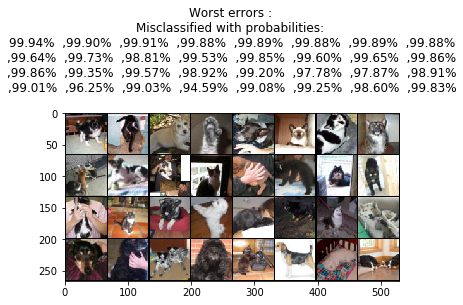

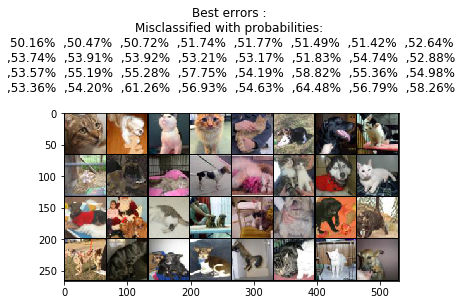

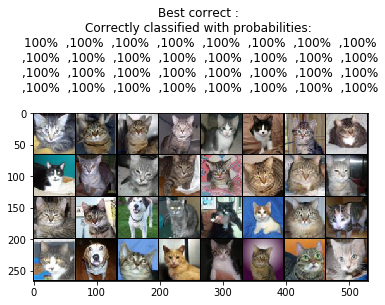

In [0]:
# What we see when we execute the notebook : 
loading_path = "./output/certainty_classification_A.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/certainty_classification_B.png"
IPython.display.display(IPython.display.Image(filename=loading_path))
loading_path = "./output/certainty_classification_C.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

If we, in fact, plot the histograms of the misclassifications and correct classifications (for 2 of our models, Classifier5 and VGGClassifier) we can see that, on expectation, the model is far more confident when it predicts correct labels than misclassified cases (and in the case of Classifier5, when it missclassifies a picture it seems to do it with a not far from uniformly distributed certainty). This is a good thing, it indicates that in a real-world application where it is acceptable to label a picture "i don't know" instead of just "cat" and "dog", one could set a threshold parameter that controls the confidence level below which the nets says "i don't know". The fact that the fraction of missclassified pictures increases as the confidence level of the net decreases render this threshold parameter meaningful. It could be useful in a context where we want to avoid false-positive (i.e. wrong labels) and are fine with not labeling all the pictures. 

We also note that one model (VGGClassifier) seems to find it (slightly) more easy to recognize cats than dogs (119 cat errors vs 163 dog errors) and for the other model (Classifier5) the reverse is true (i.e. 209 cat errors vs 151 dogs errors). From this fact, we cannot conclude that the task of recognizing either cats or dogs with high certainty is more difficult than recognizing the other.

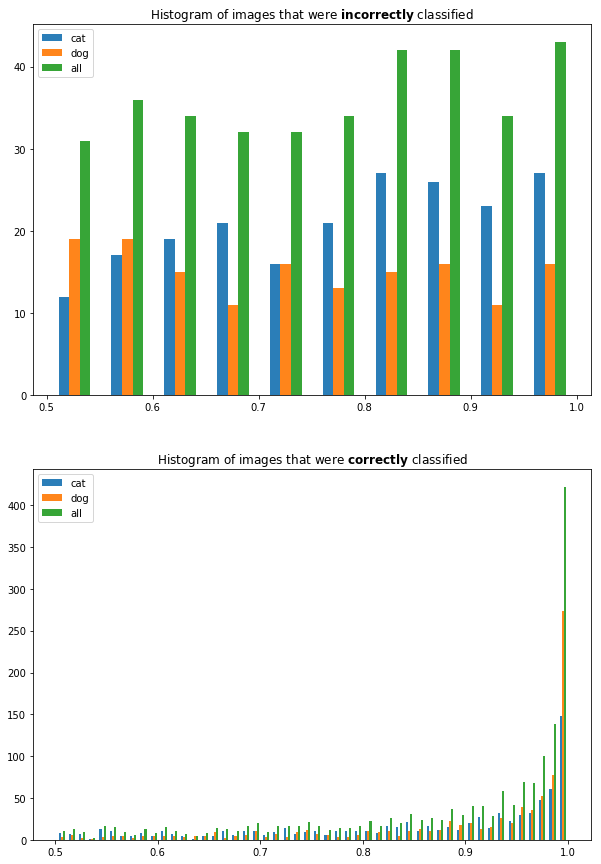

In [0]:
plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(10,15))
plt.subplot(2, 1, 1)
plt.title(r"Histogram of images that were $\bf{incorrectly}$ classified")
cat_hist_ = torch.FloatTensor(negativehisto[0]).numpy()
dog_hist_ = torch.FloatTensor(negativehisto[1]).numpy()
all_hist_ = torch.FloatTensor(negativehisto[0]+negativehisto[1]).numpy()
plt.hist([cat_hist_,dog_hist_,all_hist_],bins=10,rwidth=0.6, alpha=0.95, label=['cat', 'dog', 'all'])
plt.legend(loc='upper left')
plt.subplot(2, 1, 2)
plt.title(r"Histogram of images that were $\bf{correctly}$ classified")
cat_hist_ = torch.FloatTensor(positivehisto[0]).numpy()
dog_hist_ = torch.FloatTensor(positivehisto[1]).numpy()
all_hist_ = torch.FloatTensor(positivehisto[0]+positivehisto[1]).numpy()
plt.hist([cat_hist_,dog_hist_,all_hist_],bins=50,rwidth=0.6, alpha=0.95, label=['cat', 'dog', 'all'])
plt.legend(loc='upper left')
plt.show()

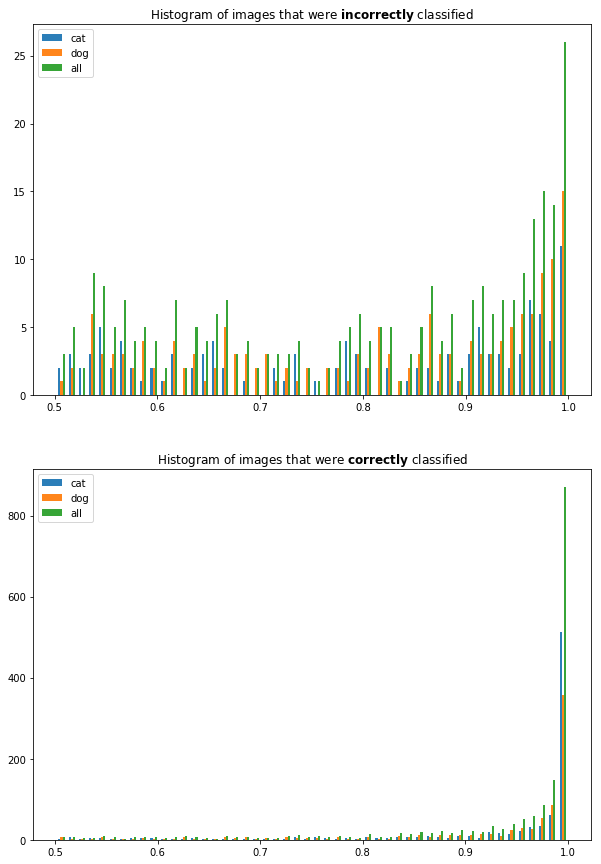

In [0]:
# What we see when we execute the notebook with VGGClassifier: 
loading_path = "./output/classification_histogram_vgg_A.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

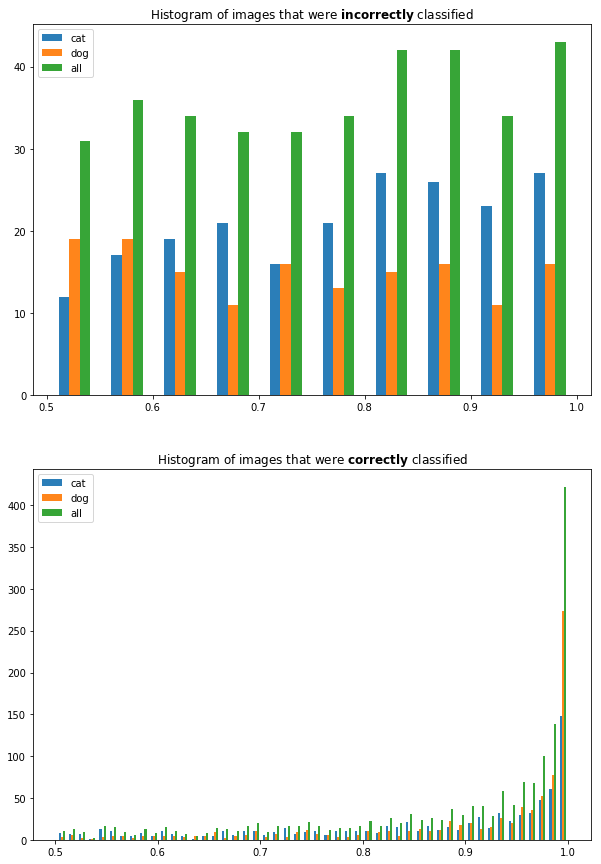

In [0]:
# What we see when we execute the notebook with Classifier5: 
loading_path = "./output/classification_histogram_class5_A.png"
IPython.display.display(IPython.display.Image(filename=loading_path))

### Visualize feature maps

We further want to look into the kernels and feature maps and see if we can see any meaningful output of them. Interpreting the feature maps in the middle layers are no trivial task as the architecture is a continuous combination of weights that are not neccessarily in the same three layered regime of RGB channels. Zeiler et al., 2011 proposed a novel way of projecting back feature maps back to the input space through an architecture called deconvolutional networks (deconvnet). Deconvnet were originally proposed for unsupervised learning, but here they are only used to inspect the model's feature maps. They use rectification, unpooling, and transpose of the kernels (used in backpropagation of CNNs) corresponding to the original convnets (refer to page 52 of Lecture_3_convnets.pdf).

Loading the pretrained model:


#### This part was done to vizualise the feature maps of the classifier5 model, so we load one we have stored. The previous cells about missclassification statistics should be re-executed using the loaded model.

In [0]:
# keep a reference to previous mynet
mynet_old = mynet

In [0]:
# load a trained Classifier5 that achieved 82% accuracy
loading_path = "./save/export/dev1num3Classifier5_82.pth"   
cudanet_tocpu = Classifier5() 
cudanet_tocpu.load_state_dict(torch.load(loading_path))
mynet = copy.deepcopy( cudanet_tocpu ).cpu()


In the following we created a deconvnet of the chosen Classifier5 helping us examining the feature maps of our Classifier5 model. We initialize its parameters with the pretrained convnet and created a user interface to probe any arbitrary layer and unit. The program was inspired from the following link: https://github.com/csgwon/pytorch-deconvnet/blob/master/models/vgg16_deconv.py

The earlier feature maps are showing how the model depicts more color detection with a subtle features encoding and some detecting facial parts. As the image progresses the images become harder to interpret, nonetheless model compose these features as to create higher order features which might be more abstract in terms of what features they amplify or attenuate.


In [0]:
# for vizualisation purpose
class Classifier5_extended(nn.Module):
    """
    Classifier5 extension for vizualisation of feature maps
    """
    def __init__(self):
        
        kernel_sz = np.array([5,5,5,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        super(Classifier5_extended, self).__init__()
        self.conv = nn.Sequential(
            # Layer, input size = 64^2
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True),
            
            # Layer 2, input size = 32^2
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True),
            
            # Layer 3, input size = 16^2
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size= (kernel_sz[2],kernel_sz[2]) , padding=pad[2]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True),

            # Layer 4, input size = 8^2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.ReLU(),

            # Layer 5
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True),
            
            # Layer 6
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True),
            
            # Layer 7
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.MaxPool2d(kernel_size=(2, 2), stride=2, return_indices=True)           
        )
        # 
        self.fct1b = nn.Linear(1*1*512, 2)
        self.feature_outputs = [0]*len(self.conv)
        self.pool_indices = dict()

    def initialize_weights_from(self, classifier5):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(classifier5.conv):
            if isinstance(layer, torch.nn.Conv2d):
                self.conv[i].weight.data = layer.weight.data
                self.conv[i].bias.data = layer.bias.data
        self.fct1b.weight.data = classifier5.fct1b.weight.data
        self.fct1b.bias.data   = classifier5.fct1b.bias.data
        
    def forward_features(self, x):
        output = x
        for i, layer in enumerate(self.conv):
            if isinstance(layer, torch.nn.MaxPool2d):
                output, indices = layer(output)
                self.feature_outputs[i] = output
                self.pool_indices[i] = indices
            else:
                output = layer(output)
                self.feature_outputs[i] = output
        return output

    def forward(self, x):
        x = self.forward_features(x)
        x = x.view(x.size()[0], -1)
        x = self.fct1b(x)
        return x

class declassifier(nn.Module):
    """Convnet Classifier"""
    def __init__(self ):
        
        kernel_sz = np.array([5,5,3,3,3,3,3,3])
        pad = kernel_sz // 2 
        pad[7] = 0 
        
        self.conv2DeconvIdx = {0:12, 3:10, 6:8, 9:6, 11:5, 14:3, 17:1}
        self.conv2DeconvBiasIdx = {0:10, 3:8, 6:6, 9:5, 11:3, 14:1, 17:0}
        self.unpool2PoolIdx = {11:2, 9:5, 7:8, 4:13, 2:16, 0:18}

        super(declassifier, self).__init__()
        self.deconv_features = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=16, out_channels=3, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
        )
        self.deconv_first_layers = nn.Sequential(
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=256, kernel_size= (kernel_sz[6], kernel_sz[6]) , padding=pad[6]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=256, kernel_size= (kernel_sz[5], kernel_sz[5]) , padding=pad[5]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=128, kernel_size= (kernel_sz[4],kernel_sz[4]) , padding=pad[4]),
            nn.ConvTranspose2d(in_channels=1, out_channels=64, kernel_size= (kernel_sz[3],kernel_sz[3]) , padding=pad[3]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=32, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=16, kernel_size= (kernel_sz[1],kernel_sz[1]) , padding=pad[1]),
            nn.MaxUnpool2d(kernel_size=(2, 2), stride=2),
            nn.ConvTranspose2d(in_channels=1, out_channels=3, kernel_size= (kernel_sz[0],kernel_sz[0]) , padding=pad[0] ),
        )
        # 

    def initialize_weights_from(self, classifier5):
        # initializing weights using ImageNet-trained model from PyTorch
        for i, layer in enumerate(classifier5.conv):
            if isinstance(layer, torch.nn.Conv2d):
                self.deconv_features[self.conv2DeconvIdx[i]].weight.data = layer.weight.data
                biasIdx = self.conv2DeconvBiasIdx[i]
                if biasIdx > 0:
                    self.deconv_features[biasIdx].bias.data = layer.bias.data

    def forward(self, x, layer_number, map_number, pool_indices):
        start_idx = self.conv2DeconvIdx[layer_number]
        if not isinstance(self.deconv_first_layers[start_idx], torch.nn.ConvTranspose2d):
            raise ValueError('Layer '+str(layer_number)+' is not of type Conv2d')
        # set weight and bias
        self.deconv_first_layers[start_idx].weight.data = self.deconv_features[start_idx].weight[map_number].data[None, :, :, :]
        self.deconv_first_layers[start_idx].bias.data = self.deconv_features[start_idx].bias.data        
        # first layer will be single channeled, since we're picking a particular filter
        output = self.deconv_first_layers[start_idx](x)

        # transpose conv through the rest of the network
        for i in range(start_idx+1, len(self.deconv_features)):
            if isinstance(self.deconv_features[i], torch.nn.MaxUnpool2d):
                output = self.deconv_features[i](output, pool_indices[self.unpool2PoolIdx[i]])
            else:
                output = self.deconv_features[i](output)
        return output

In [0]:
from math import sqrt, ceil
import numpy as np

def visualize_grid(Xs, ubound=255.0, padding=1):
    """
    Reshape a 4D tensor of image data to a grid for easy visualization.
    Inputs:
    - Xs: Data of shape (N, H, W, C)
    - ubound: Output grid will have values scaled to the range [0, ubound]
    - padding: The number of blank pixels between elements of the grid
    """
    (N, H, W, C) = Xs.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + padding * (grid_size - 1)
    grid_width = W * grid_size + padding * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C))
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = Xs[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = ubound * (img - low) / (high - low)
                # grid[y0:y1, x0:x1] = Xs[next_idx]
                next_idx += 1
            x0 += W + padding
            x1 += W + padding
        y0 += H + padding
        y1 += H + padding
    # grid_max = np.max(grid)
    # grid_min = np.min(grid)
    # grid = ubound * (grid - grid_min) / (grid_max - grid_min)
    return grid

def vis_grid(Xs):
    """ visualize a grid of images """
    (N, H, W, C) = Xs.shape
    A = int(ceil(sqrt(N)))
    G = np.ones((A*H+A, A*W+A, C), Xs.dtype)
    G *= np.min(Xs)
    n = 0
    for y in range(A):
        for x in range(A):
            if n < N:
                G[y*H+y:(y+1)*H+y, x*W+x:(x+1)*W+x, :] = Xs[n,:,:,:]
                n += 1
    # normalize to [0,1]
    maxg = G.max()
    ming = G.min()
    G = (G - ming)/(maxg-ming)
    return G

#### Display some feature maps
We retrieve a sample that the net correctly classified and with high confidence and use it as input. It is interesting to see some of the lower layer feature maps after especialy passing the non-linearity on some images form facial part locations. Besides, the bias towards the location facial parts, the model was observed to be particular about other biases of our dataset such as background colors.

Classifier5 model:
Classifier5_extended(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kerne

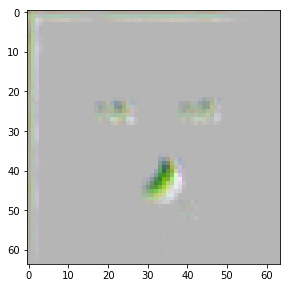

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import sys

def vis_layer(activ_map):
    plt.clf()
    plt.subplot(121)
    plt.imshow(activ_map[:,:,0], cmap='gray')

def decon_img(layer_output):
    raw_img = layer_output.data.numpy()[0].transpose(1,2,0)
    img = (raw_img-raw_img.min())/(raw_img.max()-raw_img.min())*255
    img = img.astype(np.uint8)
    return img

while True:

    n_classes = 1000 # using ImageNet pretrained weights

    #vgg16_c = VGG16_conv(n_classes)
    _ = mynet.cpu()
    mynet_extended = Classifier5_extended()
    mynet_extended.initialize_weights_from(mynet)
    cudanet_d = declassifier()
    cudanet_d.initialize_weights_from(mynet)
    
    conv_layer_indices = list(cudanet_d.conv2DeconvIdx.keys())

    #img = np.asarray(Image.open(img_filename).resize((224,224)))
    img_var = best_correct[0][1].unsqueeze(0)
    #img_var = torch.autograd.Variable(torch.FloatTensor(img.transpose(2,0,1)[np.newaxis,:,:,:].astype(float)))

    conv_out = mynet_extended(img_var)
    print('Classifier5 model:')
    print(mynet_extended)

    plt.ion() # remove blocking
    plt.figure(figsize=(10,5))

    layer = int( input('Layer to view (0-17, -1 to exit): ') )

    activ_map = mynet_extended.feature_outputs[layer].data.numpy()
    activ_map = activ_map.transpose(1,2,3,0)
    activ_map_grid = vis_grid(activ_map)
    vis_layer(activ_map_grid)

    # only transpose convolve from Conv2d or ReLU layers
    conv_layer = layer
    if conv_layer not in conv_layer_indices:
        conv_layer -= 1
        if conv_layer not in conv_layer_indices:
            raise ValueError('Invalid Layer Number')

    n_maps = activ_map.shape[0]

    map_idx = int( input('Take a map to view (0-{}): '.format(activ_map.shape[0]-1)) )

    decon = cudanet_d(mynet_extended.feature_outputs[layer][0][map_idx][None,None,:,:], conv_layer, map_idx, mynet_extended.pool_indices)
    img = decon_img(decon)
    plt.imshow(img)

The earlier feature maps are showing how the model depicts more color detection with a subtle features encoding, and as it progresses the images despite being harder to interpret how the pieces com together, but it looks as if it is forming a more defined form of cat and dog.

### vizualize kernels  
We display, a subset of kernels for each convolution layer. The kernel are small and they don't look like edge detector. There is not much else to be said.

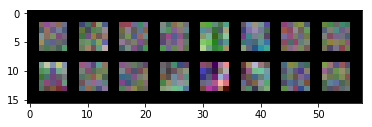

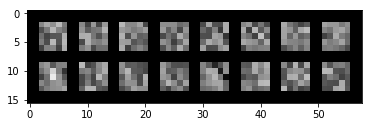

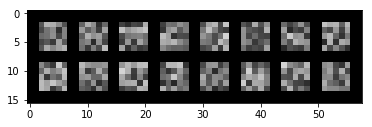

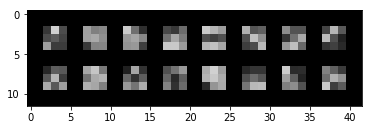

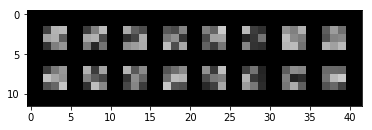

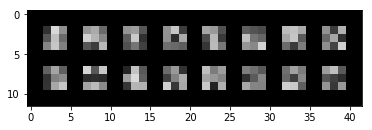

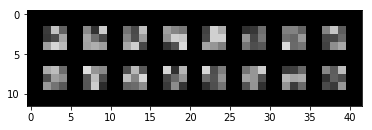

In [0]:
for i,(name, kernels) in enumerate(mynet_extended.state_dict().items()) :
    # ou "conv"
    if not ((name.startswith("features") or name.startswith("conv"))and name.endswith("weight") ):
        continue 
    if i == 0 : # 3 input channels can be displayed in color
         kernels = kernels.detach()
    else : # more than 3 input channels are displayed in greyscale
        kernels = kernels.detach().view(-1,1,kernels.size()[-1],kernels.size()[-1])
   
    kernels = kernels - kernels.min()
    kernels = 255 * kernels / kernels.max() 
    size = min(kernels.size()[0],16)
    # print( kernels.max() , kernels.min() )
    # print(kernels.size())
    imshow(torchvision.utils.make_grid(kernels[0:size,:,:,:]))

# Submit  
This part of the notebook is used for submission.

a) We define a dataset for the test samples  
b) We load the test dataset, label all picture and produce a .csv file  

In [0]:
class nonlabeledDataSet(torch.utils.data.Dataset):

    def __init__(self , nb_of_sample, root_dir ):
        """
        Args:
            label is either "Cat" or "Dog"
            load in the dataset picture no. idx_min to idx_max included
            root_dir(string): directory with all images with the same label
        """
        # super(labeledDataSet, self).__init__()  
        self.root_dir = root_dir
        self.nb_of_sample = nb_of_sample
        self.load_data()
    
    def load_data(self) :
        size = self.__len__()
        
        self.data_tensor   = torch.empty(size,3,64,64,dtype=torch.float)
        
        for i in range(self.nb_of_sample) :
            j = i + 1
            img_path = self.root_dir +  "{index}.jpg".format(index=j)
            img = Image.open( img_path ).convert('RGB')
            image = torch.from_numpy( np.transpose( img , (-1,-3,-2) ) )
            image = image
            self.data_tensor[i,:,:,:] = image
        
    def __len__(self):
        return self.nb_of_sample

    def __getitem__(self, idx):
        return self.data_tensor[idx]


In [0]:
# Test the performance of mynet before using it
criterion = nn.CrossEntropyLoss()
batch_size = 4*64
train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( mynet , train_loader, criterion )
print(a.item(), "loss : " , b.item())
a,b = measure_single_accuracy_and_loss( mynet , valid_loader, criterion )
print(a.item(), "loss : " , b.item())

97.13873291015625 loss :  0.00036534047103486955
86.59329986572266 loss :  0.0013806667411699891


In [0]:
testset_dir        = "./data_catdogs/testset/test/"
batch_size         = 4*64
total_nb_of_sample = 4999 # total number of total unlabelled test samples
test_dataset = nonlabeledDataSet(total_nb_of_sample,testset_dir)
test_loader  = DataLoader(test_dataset, batch_size=batch_size,shuffle=False, num_workers=num_workers)

def class_from_index(ind):
    return train_dataset_norm.classes[ind]

remember_prediction = torch.empty(batch_size)
with open('submission4.csv', mode='w') as submission:
    submission.write('id,label\n')
    i = 1
    for query in test_loader:
        img = query
        with torch.no_grad():
            img          = img.to(device)
            outputs      = mynet(img).squeeze()
            _, predicted = torch.max(outputs.data, 1)
            if i == 1 :
                remember_prediction = copy.deepcopy(predicted).cpu()
            for j in range(predicted.shape[0]) :
                idx    = predicted[j]
                label  = class_from_index(idx)
                submission.write('{},{}\n'.format(i,label) )
                i = i + 1

#### For sanity
We have manually labeled the first 100 pictures to be certain that the data loader used was not feeding the pictures in the wrong order. Previously, we had this issue.

In [0]:
good_test_answers = torch.zeros(100,dtype=torch.long)
dog_idx = [2,4,6,7,8,14,16,17,19,20,22,24,26,29,31,32,39,41,43,45,53,58,61,
           63,69,70,71,74,75,76,77,82,83,84,86,87,89,93,94,97,98,99]
for i in dog_idx :
    good_test_answers[i-1] = 1
    
count = 0
prediction = remember_prediction[:100]
for i in range(100):
    if prediction[i] == good_test_answers[i] :
        count = count + 1
print("Number of good answer for first 100 samples : " , count) 

Number of good answer for first 100 samples :  86


#### For sanity also  
Manually check that the loader loads the picture in the good order.

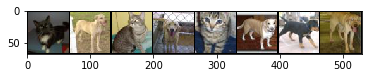

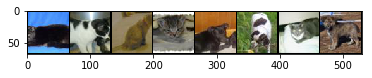

In [0]:
test_pict_loader  = DataLoader(test_dataset, batch_size=8,shuffle=False, num_workers=num_workers)
for i, img in enumerate(test_pict_loader):
    if i > 1 :
        break
    imshow(torchvision.utils.make_grid(img))

# Save and load models

#### Load

In [0]:
# On github
loading_path = "./save/export/dev1num3Classifier5_82.pth"    # Classifier5() with 82% accuracy
# loading_path = "./save/export/dev1num3VGGClassifier5_85.pth" # VGGClassifier() with 85% accuracy
# loading_path = "./save/export/dev1num3VGGClassifier_86.pth"  # VGGClassifier() with 86% accuracy

# Locally only
# loading_path = "./save/classifier1_201to500/dev1num3model_for_epoch300.pth" # Classifier1()
# loading_path = "./save/underfit201to300/dev1num3model_for_epoch100.pth" # Classifier5d()
# loading_path = "./save/classifier5wsm_nocrop_51to100/dev1num3model_for_epoch50.pth" # Classifier5()

# cudanet_tocpu = VGGClassifier() 
cudanet_tocpu = Classifier5() 
cudanet_tocpu.load_state_dict(torch.load(loading_path))
mynet = copy.deepcopy( cudanet_tocpu ).to(device)

#### Save

In [0]:
# save current state only
# saving_path = "./save/export/dev1num3model.pth"
saving_path = "./save/export/"
saving_name = "dev1num3BLABLA.pth"
_ = mynet.cpu()
state_dict_to_disk = mynet.state_dict()
torch.save( state_dict_to_disk , saving_path )
_ = mynet.to(device)

#### Measure accuracy and average loss on training and validation dataset  
This is usefull is you load a previously saved model and want to measure its performance.

In [0]:
# mynet  = Classifier5()
# mynet.load_state_dict(net1_state_dict_list[30])
mynet = cudanet2
_ = mynet.to(device)

criterion_sum = nn.CrossEntropyLoss(reduction='sum')
batch_size = 4*64
# train_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)
valid_loader = DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
a,b = measure_single_accuracy_and_loss( mynet , train_loader, criterion_sum )
print("Training dataset")
print("accuracy : " , a.item(), "loss : " , b.item())
a,b = measure_single_accuracy_and_loss( mynet , valid_loader, criterion_sum )
print("Validation dataset")
print("accuracy : " , a.item(), "loss : " , b.item())

# Other comments  

### Use majority vote  
Use and odd number of net to find what they each think of a picture and take the majority vote among them.  
This is usefull to see if multiple nets "are independant sources of information" or if "they all learnt the same things".  
We used this method together with 3 different models achieving at least 80% accuracy on the validation dataset :
- Classifier5  (trained using medium-low data augmentation)
- Classifier7  (trained using medium data augmentation)
- VGGClassifier (trained using medium-low data augmentation)
We found that this method could be used to improve the performance of the best of the 3 models by about 1%. 

If we take the majority vote for yes-no questions using 3 independants voters that vote randomly with 80% accuracy each. The probability of the outcome of the vote to be right is :  
- Prob(3 are right) + 3 Prob(2 are right)Prob(1 is wrong) = Prob(1 is right)^3 +  3 Prob(1 is right)^2 Prob(1 is wrong)  = (0.8)^3 + 3(0.8)^2(0.2) = 0.896  

This indicates that the three models we have tested cannot possibly be considered as independant. Even with different architectures, the 3 models have learnt very similar things about the classification task.  

In [0]:
cudanet1 = Classifier5()
_ = cudanet1.to(device)
cudanet2 = Classifier5()
_ = cudanet2.to(device)
cudanet3 = Classifier5()
_ = cudanet3.to(device)

In [0]:
batch_size = 4*64

# with or without data augmentation
validation_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)
# validation_loader = torch.utils.data.DataLoader(train_dataset_augm, batch_size=batch_size,sampler=valid_sampler, num_workers=num_workers)

# If set to true, the answers of the 
majority_by_confidence = False

correct = torch.tensor([0])
total = torch.tensor([0])
   
correct, total = correct.to(device) , total.to(device) 
with torch.no_grad():
    for data in validation_loader:
        images, labels = data
        # if using BCE
        # labels = labels.float()
        images, labels = images.to(device), labels.to(device)
        
        if majority_by_confidence :
            outputs =  torch.softmax(cudanet1(images),dim=-1) + torch.softmax(cudanet2(images),dim=-1) + torch.softmax(cudanet3(images),dim=-1) 
            _, predicted = torch.max(outputs.data, 1)
        else :
            outputs = cudanet1(images)
            _, predicted1 = torch.max(outputs.data, 1)
            outputs = cudanet2(images)
            _, predicted2 = torch.max(outputs.data, 1)
            outputs = cudanet3(images)
            _, predicted3 = torch.max(outputs.data, 1)
            predicted , _ = torch.mode(torch.cat((predicted1.unsqueeze(1),predicted2.unsqueeze(1),predicted3.unsqueeze(1)),-1).squeeze(),-1)
        # print(predicted1.shape)
        # print(predicted.shape)
        total += labels.size(0)
        correct += (predicted == labels).sum()

print('Accuracy of the network on the' , total.item() , 'test images: %.2f %%' 
          % ( (100 * correct.double()) / total.double()  )
     ) 

Accuracy of the network on the 1999 test images: 48.42 %


### Find a good initialization  
The following code is usefull to find a good initialization if finding one appears to be hard work. We used this code to make sure that certain configurations did not work at all (such as mapping the picture in the [0 1] interval instead of [0 255]).  
It works as follow :   
Try different random init, train them for 3 epoch, repeat until you find one than has learnt something or the number of tries reach a certain threshold.   

In [0]:
# del cudanet 
nb_epoch  = 1
nb_try    = 10
batch_size = 1*16
train_loader = torch.utils.data.DataLoader(train_dataset_norm, batch_size=batch_size,sampler=train_sampler, num_workers=num_workers)

state_dict_list = list()

torch.cuda.synchronize()

start = torch.cuda.Event(enable_timing=True)
end   = torch.cuda.Event(enable_timing=True)
start.record()

for trial in range(nb_try) :
    cudanet = Classifier5()
    # cudanet = Classifier1b(sigmoid=True)
    cudanet.apply( glorot_init )
    _ = cudanet.to(device)
    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(cudanet.parameters(), lr=0.00025, momentum=0, weight_decay=0)
    optimizer = optim.SGD(cudanet.parameters(), lr=0.0001, momentum=0, weight_decay=0)
    correct = torch.tensor([0])
    total = torch.tensor([0])
    for epoch in range( nb_epoch ):  # loop over the dataset multiple times 

        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader, 0):
            # if using BCE :
            # labels = labels.float() 
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = cudanet(inputs).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            with torch.no_grad() :
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum()
        else : # print every epoch
            print('trial %d , epoch = %d, loss = %.8f' % (trial + 1, epoch + 1, running_loss / training_dataset_size)) # nb of sample per mini-batch
            running_loss = 0.0
            torch.cuda.synchronize()
            tmp_state_dict = {}
            for k, v in cudanet.state_dict().items():
                tmp_state_dict[k] = v.cpu()
            state_dict_list.append( tmp_state_dict )
            torch.cuda.synchronize()
    accuracy = 100*correct.double()/total.double()
    print("Accuracy for trial %d : %.4f %%" % (trial+1 , accuracy) )
    if accuracy > 53 :
        print('Successful search')
        break
    del cudanet
else : 
    print('Unsuccessful search')
    
end.record()
torch.cuda.synchronize()

print( "time required = " , start.elapsed_time(end)*0.001 , " s ")
if want_lound_warning :
    Audio(wave, rate=10000, autoplay=True)